# Experiment - RBIG Sample Consistency

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
pysim_root = "/home/emmanuel/code/pysim"
rbig_root = "/home/emmanuel/code/rbig"
# append to path
sys.path.append(str(rbig_root))
sys.path.append(str(pysim_root))

import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
import corner

sns.set_context(context="poster", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Mutual Information

In [2]:
# ==========================
# INITIALIZE LOGGER
# ==========================
import wandb

wandb_logger = wandb.init(project="rbig4it", entity="ipl_uv")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Dataset

In [13]:
from pysim.data.information.gaussian import (
    generate_gaussian_data,
    generate_gaussian_rotation_data,
)
from pysim.data.information.linear import generate_linear_entropy_data
from pysim.data.information.studentt import generate_studentt_data
from functools import partial
from pysim.information.entropy import marginal_entropy
from pysim.information.histogram import hist_entropy
from typing import NamedTuple


def get_tc_datasets(n_samples, n_features, seed, dataset="gaussian", **kwargs):

    if dataset == "gaussian":

        res = generate_gaussian_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
        )

    elif dataset == "gaussian_rotation":

        res = generate_gaussian_rotation_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
        )

    elif dataset == "linear_rotation":

        f = partial(marginal_entropy, estimator=hist_entropy, bins="sqrt")

        res = generate_linear_entropy_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            marg_h_estimator=f,
            estimator_name="histogram",
            n_base_samples=500_000,
        )
    elif dataset == "studentt":

        res = generate_studentt_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
            df=kwargs.get("df", 3.0),
        )

    elif dataset == "cauchy":

        res = generate_studentt_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
            df=1.0,
        )

    else:
        raise ValueError(f"Unrecognized dataset.")

    return res

In [14]:
datasets = [
    "gaussian",
    "gaussian_rotation",
    "linear_rotation",
    "studentt",
    "cauchy",
]

In [15]:
for idataset in datasets:
    res = get_tc_datasets(n_samples=10_000, n_features=10, seed=42, dataset=idataset)

    fig = corner.corner(res.X, hist_factor=2, color="red")
    plt.tight_layout()
    plt.gcf()
    wandb.log({f"data_{idataset}_X": wandb.Image(fig)})
    plt.close(fig)

### Estimators

In [16]:
from pysim.information.gaussian import gauss_total_corr
from mutual_info.mutual_info import entropy as mi_entropy
from npeet.entropy_estimators import entropy as npeet_entropy
from rbig.rbig import RBIG
import time
from scipy import stats


class TCResult(NamedTuple):
    time: float
    TC: float
    name: str


def total_correlation(X, f, **kwargs):

    return np.sum([f(ix[:, None], **kwargs) for ix in X.T]) - f(X, **kwargs)


def get_tc_estimators(X, method="gaussian", **kwargs):

    if method == "gaussian":
        t0 = time.time()
        res = gauss_total_corr(X=X.copy())
        t1 = time.time() - t0
        return TCResult(t1, res, "gaussian")

    elif method == "knn_nbs":
        t0 = time.time()
        res = total_correlation(X, mi_entropy, k=10, transform=None)
        t1 = time.time() - t0
        return TCResult(t1, res, "knn_nbs")

    elif method == "knn_eps":
        t0 = time.time()
        res = total_correlation(X, npeet_entropy, k=10, base=np.e)
        t1 = time.time() - t0
        return TCResult(t1, res, "knn_eps")

    elif method == "rbig":
        from rbig.rbig import RBIG

        t0 = time.time()
        rbig_model = RBIG(pdf_extension=10)
        rbig_model.fit(X.copy())
        res = rbig_model.mutual_information * np.log(2)
        t1 = time.time() - t0
        return TCResult(t1, res, "rbig")
    else:
        raise ValueError(f"Unrecognized estimator.")

## Toy Data

In [19]:
from pysim.utils import dict_product


datasets = [
    "gaussian",
    "gaussian_rotation",
    "linear_rotation",
    "studentt",
    "cauchy",
]
n_samples = [100, 1_000, 10_000, 100_000]

params = {
    "n_features": [2, 3, 5, 10, 15],
    "n_trials": list(np.arange(1, 11)),
    "dataset": datasets,
}
params = dict_product(params)

models = [
    "gaussian",
    "knn_nbs",
    "knn_eps",
    "rbig",
]

### Gaussian

**Implementation Notes**:

1. We randomly generate a positive semi-definite $D \times D$ matrix. This acts as our covariance matrix $\boldsymbol{\Sigma}$.

2. We use a mean, $\boldsymbol{\mu}$ of $\mathbf{0}$.

3. We generate an upper limit of 5e5 data points and then random subset the requested number.

In [20]:
from functools import partial
from tqdm.autonotebook import tqdm, trange

In [ ]:
import tqdm
import pandas as pd

results_df = pd.DataFrame()
results_dict = {}

with tqdm.tqdm(params) as pbar:

    for i, iparam in enumerate(pbar):

        # generate data
        res_tuple = get_tc_datasets(
            n_samples=200_000,
            n_features=iparam["n_features"],
            seed=iparam["n_trials"],
            dataset=iparam["dataset"],
        )

        #         results_dict = {**results_dict, **iparam}
        #         results_dict["model"] = "true"
        #         results_dict["dataset"] = iparam["dataset"]
        #         results_dict["tc"] = res_tuple.TC

        #         results_dict["time"] = 0.0

        #         results_df = pd.concat(
        #             [results_df, pd.DataFrame(results_dict, index=[i])], axis=0
        #         )

        rng = np.random.RandomState(iparam["n_trials"])

        for isamples in n_samples:

            # Subsample data
            sub_idx = rng.choice(np.arange(res_tuple.X.shape[0]), isamples)

            X_sub = res_tuple.X[sub_idx]

            for imodel in models:

                pbar.set_description(
                    f"Features: {iparam['n_features']} | Trial: {iparam['n_trials']} | Samples: {isamples} | Models: {imodel}"
                )

                # KNN (NEIGHBOURS)

                # do calculation
                res = get_tc_estimators(X=X_sub.copy(), method=imodel)

                results_dict = {**results_dict, **iparam}
                results_dict["model"] = res.name
                results_dict["dataset"] = iparam["dataset"]
                results_dict["approx"] = res.TC
                results_dict["true"] = res_tuple.TC
                results_dict["time"] = res.time
                results_dict["n_samples"] = isamples
                results_dict["n_features"] = iparam["n_features"]

                results_df = pd.concat(
                    [results_df, pd.DataFrame(results_dict, index=[i])], axis=0
                )

Features: 15 | Trial: 5 | Samples: 100000 | Models: rbig:  90%|████████▉ | 224/250 [4:46:23<1:44:46, 241.80s/it]     

In [ ]:
results_df.tail()

In [ ]:
results_df.to_csv("./rbig_consistency.csv")

In [ ]:
wandb.log({"results": wandb.Table(dataframe=results_df)})

In [36]:
import json

with open("./temp_res.json") as json_data:
    data = json.load(json_data)

results_df = pd.DataFrame(data["data"], columns=data["columns"])
results_df.head()

n_samples  n_features  n_trials   dataset     model        mi      time  \
0       1000           1         1  gaussian      true  0.452329  0.000000   
1       1000           1         1  gaussian  gaussian  0.452329  0.002186   
2       1000           1         1  gaussian        rv  0.452329  0.000250   
3       1000           1         1  gaussian   knn_nbs  0.452329  0.024578   
4       1000           1         1  gaussian   knn_eps  0.452329  0.011041   

     approx      true  
0  0.000000  0.000000  
1  0.451450  0.452329  
2  0.593796  0.452329  
3  0.414026  0.452329  
4  0.428369  0.452329

In [72]:
results_df_approx = results_df.copy()

In [73]:
def create_results_xr(df):

    df = df[df["n_samples"] != 100]

    # make index the experiment params
    df = df.set_index(["model", "n_samples", "n_features", "n_trials", "dataset"])

    #
    df_xr = df.to_xarray()

    return df_xr


def get_mu_std(ds):

    # mean
    mu = ds.mean(dim="n_trials")

    # standard deviation
    std = ds.std(dim="n_trials")

    return mu, std

In [74]:
results_xr = create_results_xr(results_df_approx)

In [75]:
results_xr

<xarray.Dataset>
Dimensions:     (dataset: 5, model: 4, n_features: 5, n_samples: 3, n_trials: 10)
Coordinates:
  * model       (model) object 'gaussian' 'knn_eps' 'knn_nbs' 'rbig'
  * n_samples   (n_samples) int64 1000 10000 100000
  * n_features  (n_features) int64 2 3 5 10 15
  * n_trials    (n_trials) int64 1 2 3 4 5 6 7 8 9 10
  * dataset     (dataset) object 'cauchy' 'gaussian' ... 'studentt'
Data variables:
    approx      (model, n_samples, n_features, n_trials, dataset) float64 0.7...
    true        (model, n_samples, n_features, n_trials, dataset) float64 0.6...
    time        (model, n_samples, n_features, n_trials, dataset) float64 0.0...

In [76]:
def plot_results(results_xr, dataset="gaussian", n_features=2):

    fig, ax = plt.subplots(figsize=(10, 5))

    # True
    mu, std = get_mu_std(
        results_xr.sel(model="gaussian", n_features=n_features, dataset=dataset).true
    )

    mu.plot.line(ax=ax, x="n_samples", color="Black", linewidth=5, label="Truth")
    ax.plot(mu.n_samples, mu.values + std.values, linestyle="--", color="gray")
    ax.plot(mu.n_samples, mu.values - std.values, linestyle="--", color="gray")
    ax.fill_between(
        mu.n_samples,
        mu.values - std.values,
        mu.values + std.values,
        alpha=0.3,
        color="gray",
    )

    # Gaussian Approximation
    mu, std = get_mu_std(
        results_xr.sel(model="gaussian", n_features=n_features, dataset=dataset).approx
    )

    mu.plot.line(
        ax=ax, x="n_samples", color="Green", linewidth=5, label=r"Gaussian",
    )
    ax.plot(mu.n_samples, mu.values + std.values, linestyle="--", color="green")
    ax.plot(mu.n_samples, mu.values - std.values, linestyle="--", color="green")
    ax.fill_between(
        mu.n_samples,
        mu.values - std.values,
        mu.values + std.values,
        alpha=0.3,
        color="green",
    )

    # KNN
    mu, std = get_mu_std(
        results_xr.sel(model="knn_nbs", n_features=n_features, dataset=dataset).approx
    )

    mu.plot.line(
        ax=ax, x="n_samples", linewidth=5, color="Orange", label=r"$k$-Neighbours"
    )
    ax.plot(mu.n_samples, mu.values + std.values, linestyle="--", color="orange")
    ax.plot(mu.n_samples, mu.values - std.values, linestyle="--", color="orange")
    ax.fill_between(
        mu.n_samples,
        mu.values - std.values,
        mu.values + std.values,
        alpha=0.3,
        color="orange",
    )
    # KNN (Epsilon)
    mu, std = get_mu_std(
        results_xr.sel(model="knn_eps", n_features=n_features, dataset=dataset).approx
    )

    mu.plot.line(
        ax=ax, x="n_samples", linewidth=5, color="Blue", label=r"$\epsilon$-Neighbours"
    )
    ax.plot(mu.n_samples, mu.values + std.values, linestyle="--", color="blue")
    ax.plot(mu.n_samples, mu.values - std.values, linestyle="--", color="blue")
    ax.fill_between(
        mu.n_samples,
        mu.values - std.values,
        mu.values + std.values,
        alpha=0.3,
        color="blue",
    )
    # RBIG
    mu, std = get_mu_std(
        results_xr.sel(model="rbig", n_features=n_features, dataset=dataset).approx
    )

    mu.plot.line(ax=ax, x="n_samples", linewidth=5, color="Red", label=r"RBIG")
    ax.plot(mu.n_samples, mu.values + std.values, linestyle="--", color="red")
    ax.plot(mu.n_samples, mu.values - std.values, linestyle="--", color="red")
    ax.fill_between(
        mu.n_samples,
        mu.values - std.values,
        mu.values + std.values,
        alpha=0.3,
        color="red",
    )
    ax.set_ylabel("Total Correlation", fontsize=20)
    ax.set_xlabel("Number of Samples", fontsize=20)
    ax.grid(which="both")
    ax.set_xscale("log")
    ax.set_title("")
    ax.legend()
    plt.gcf()
    wandb.log({f"consistency_{dataset}_{n_features}": wandb.Image(fig)})
    plt.show()
    plt.close(fig)

gaussian
Dimensions: 2


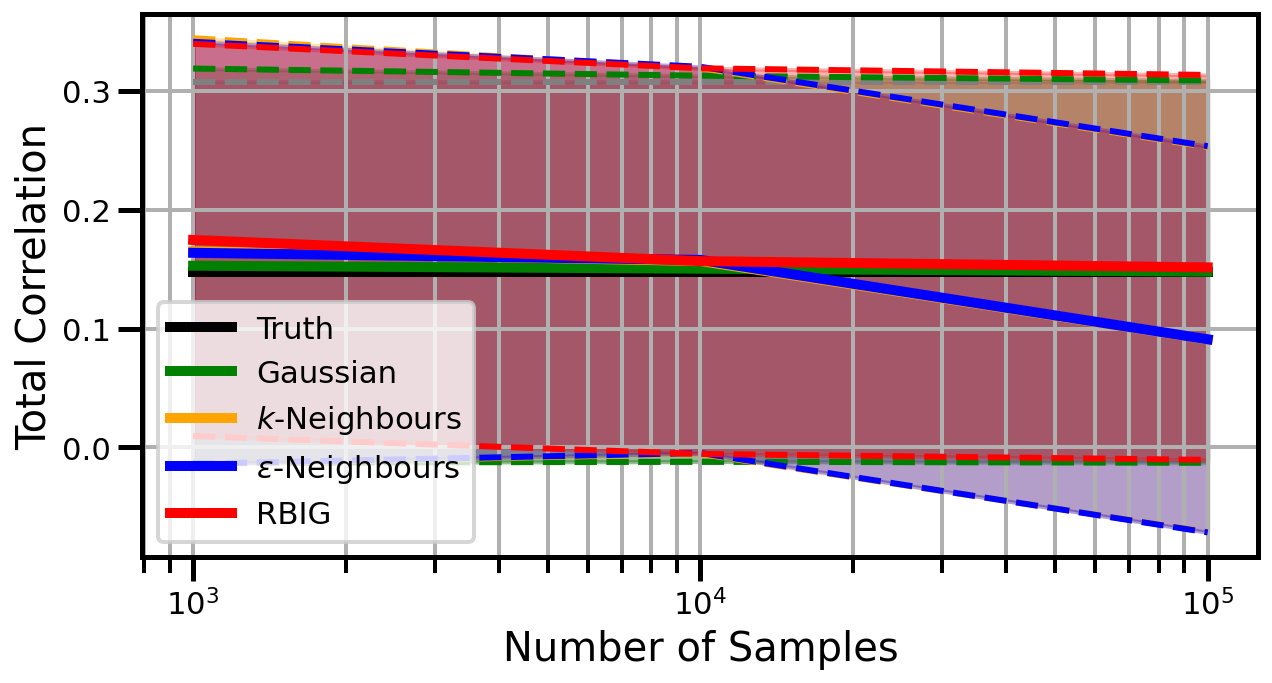

Dimensions: 3


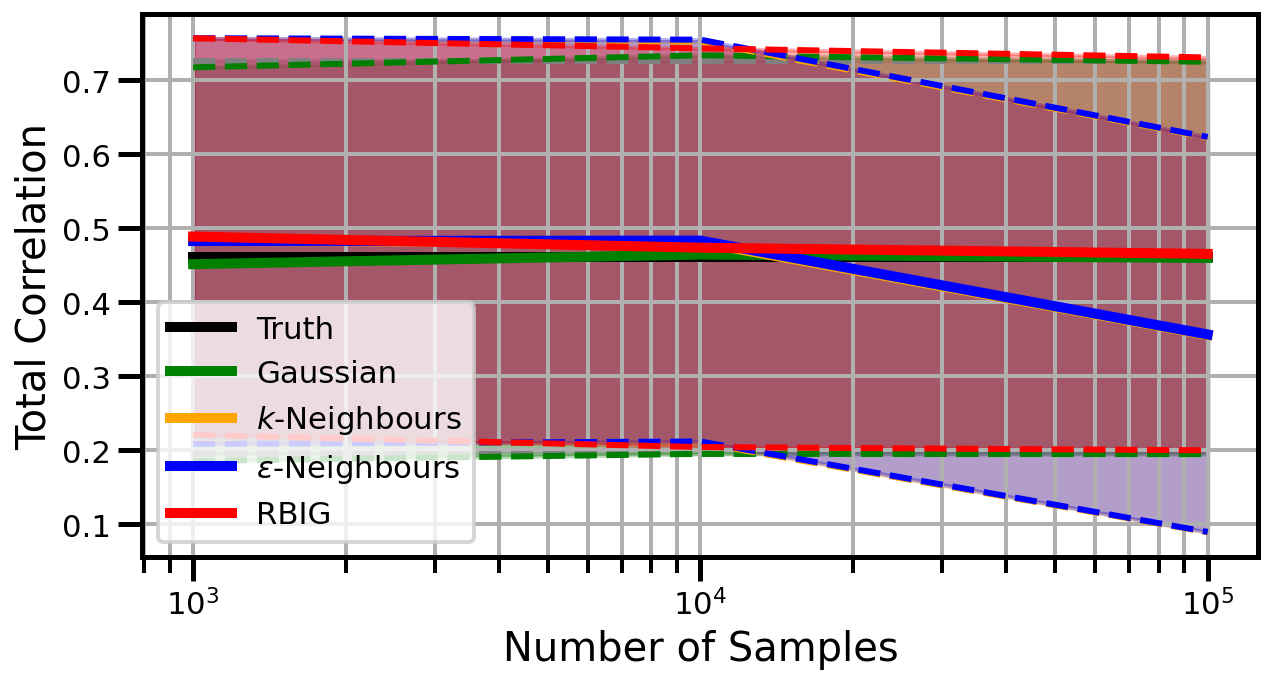

Dimensions: 5


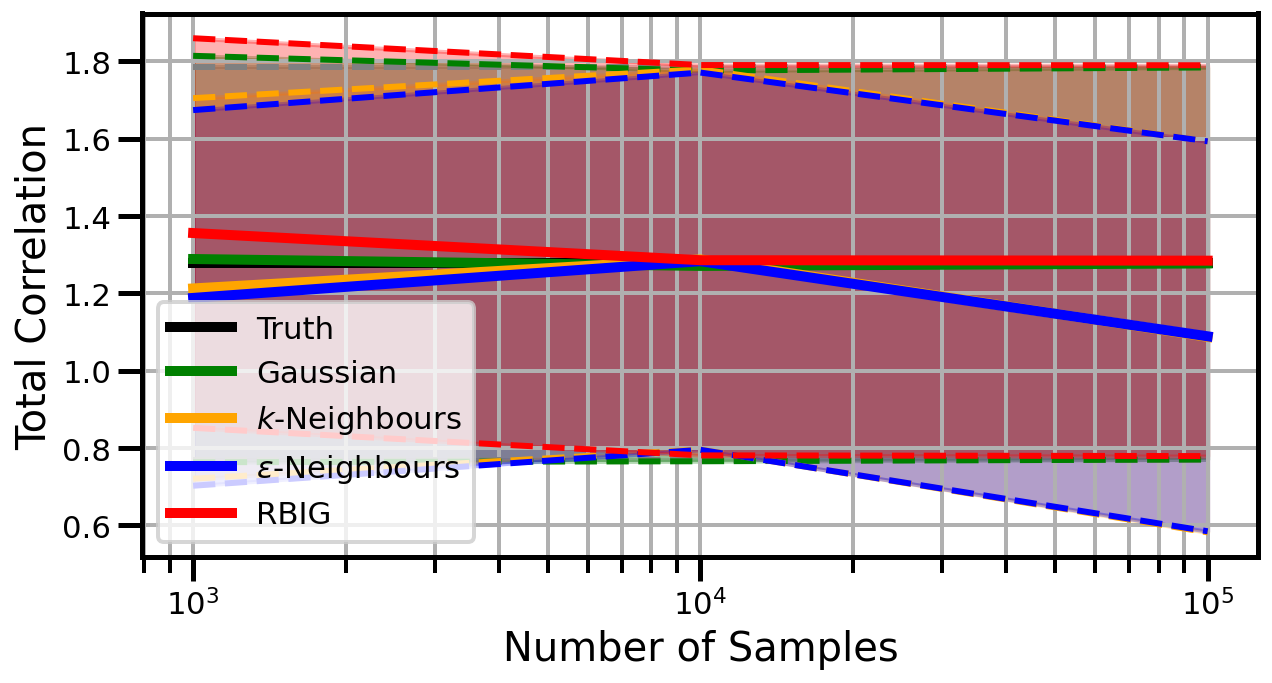

Dimensions: 10


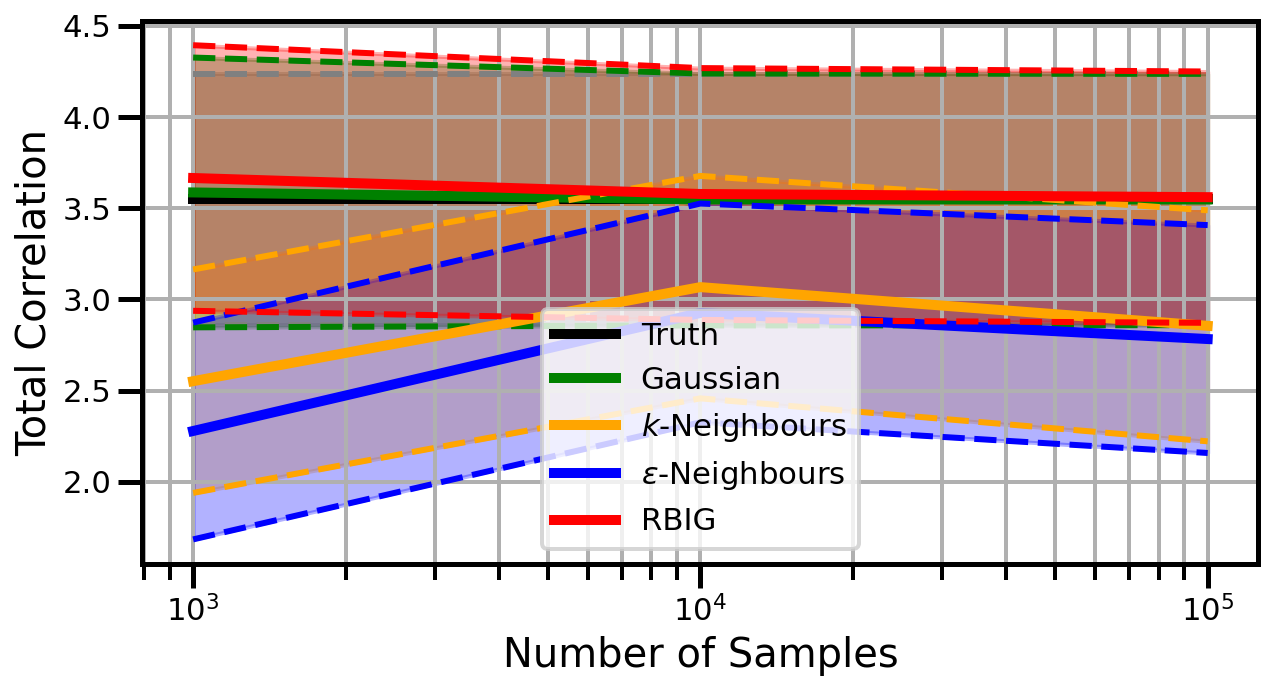

Dimensions: 15


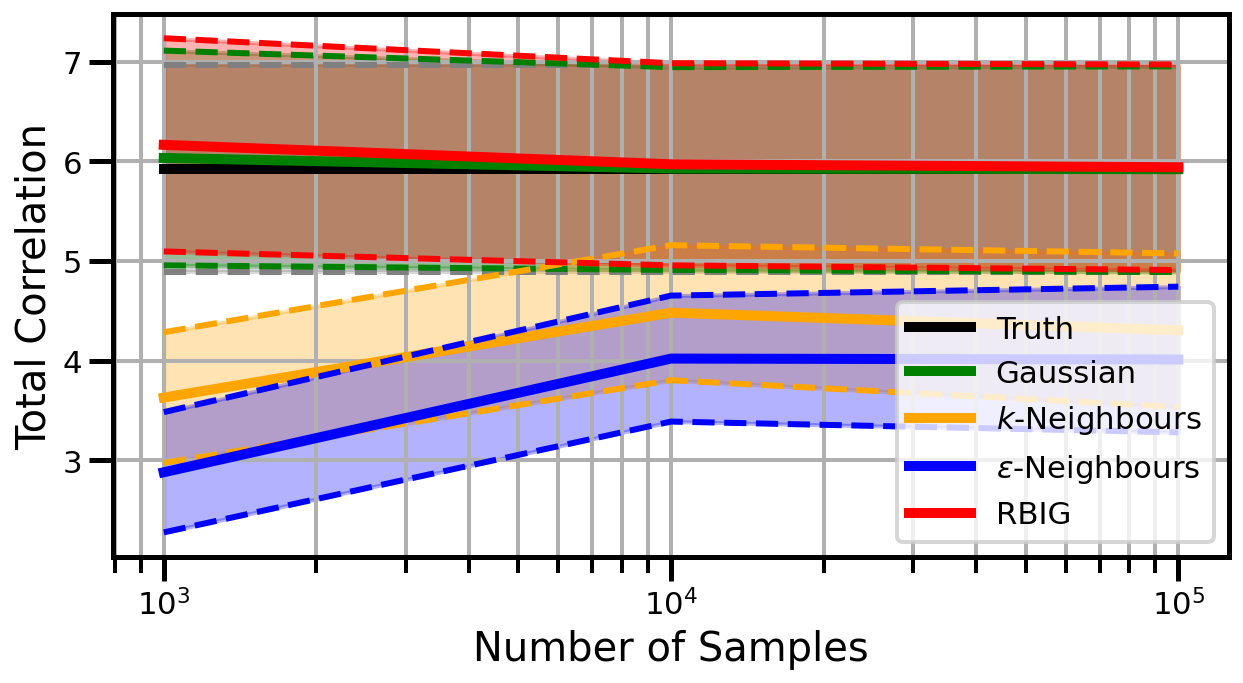

gaussian_rotation
Dimensions: 2


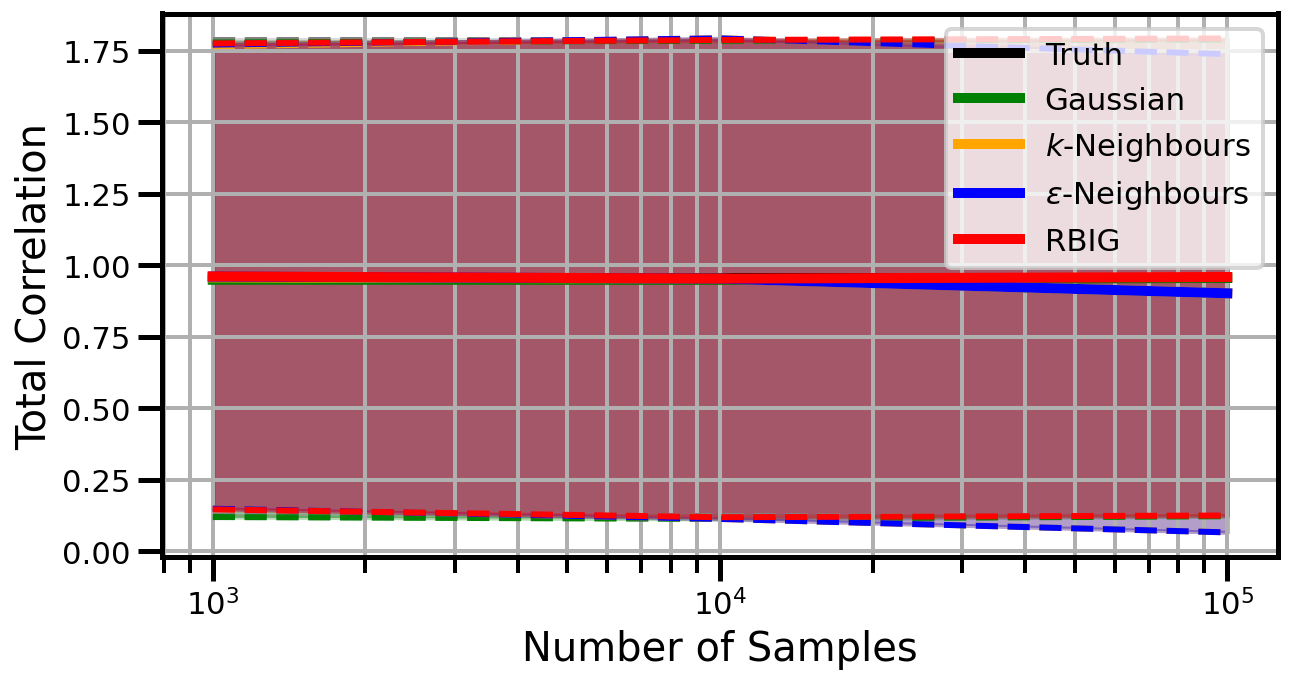

Dimensions: 3


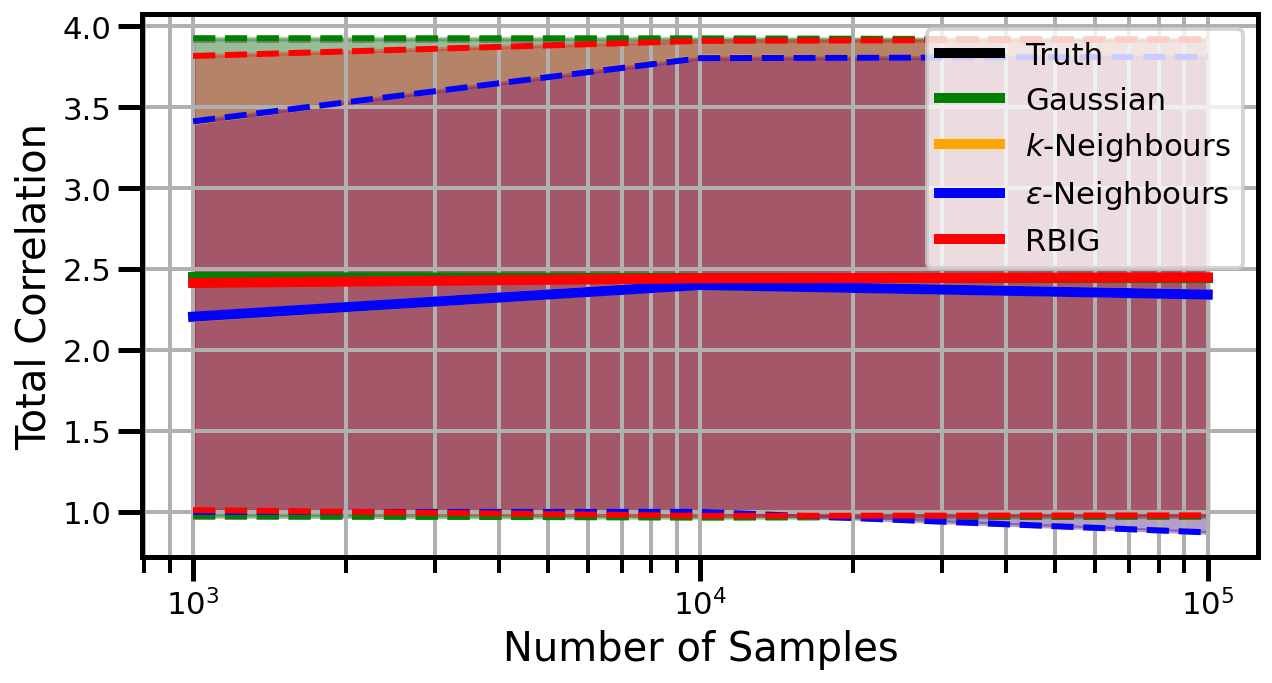

Dimensions: 5


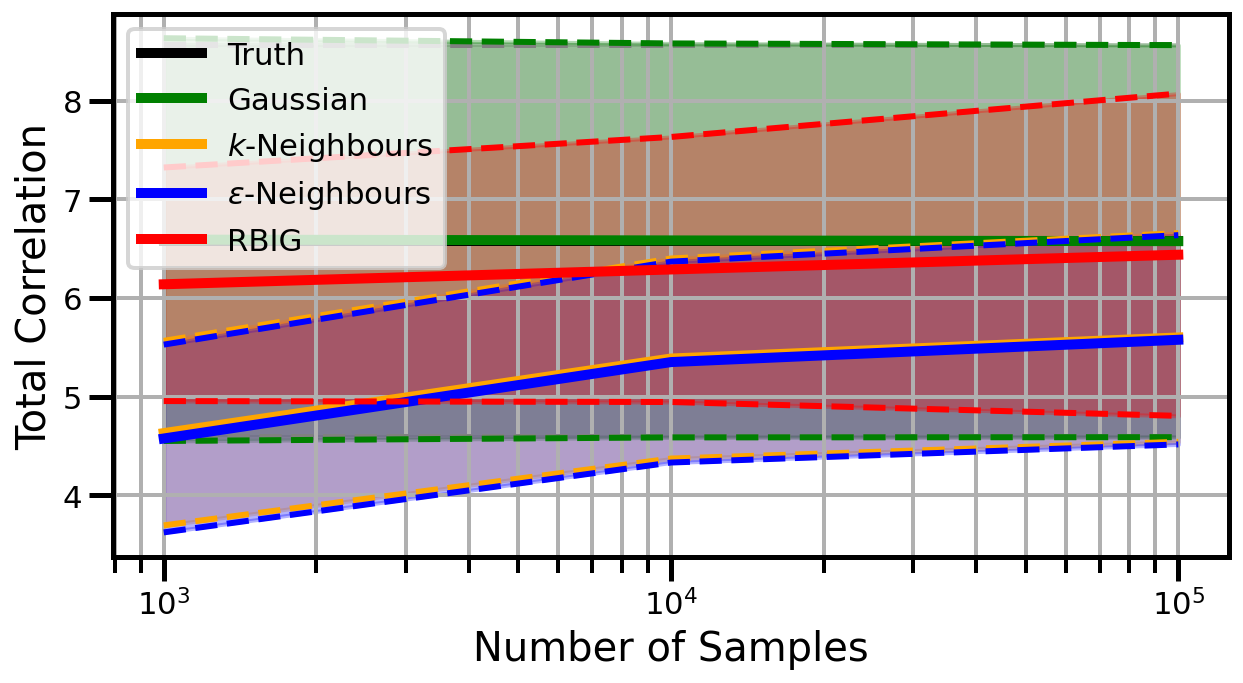

Dimensions: 10


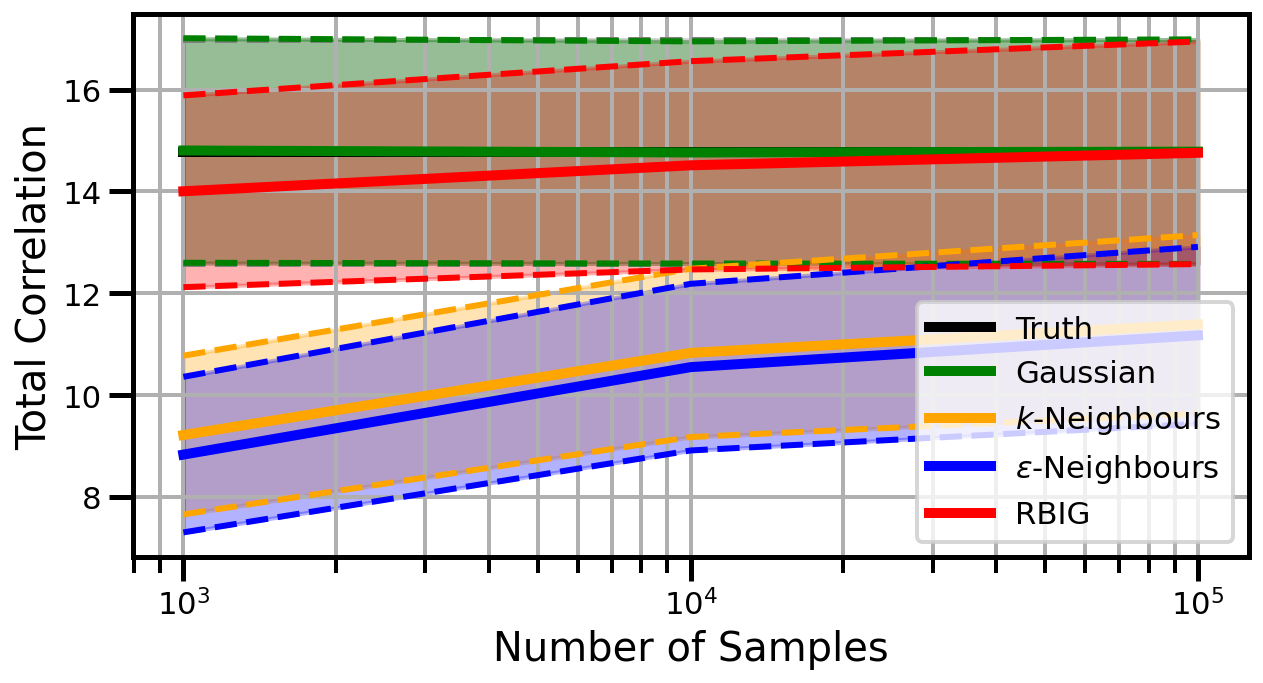

Dimensions: 15


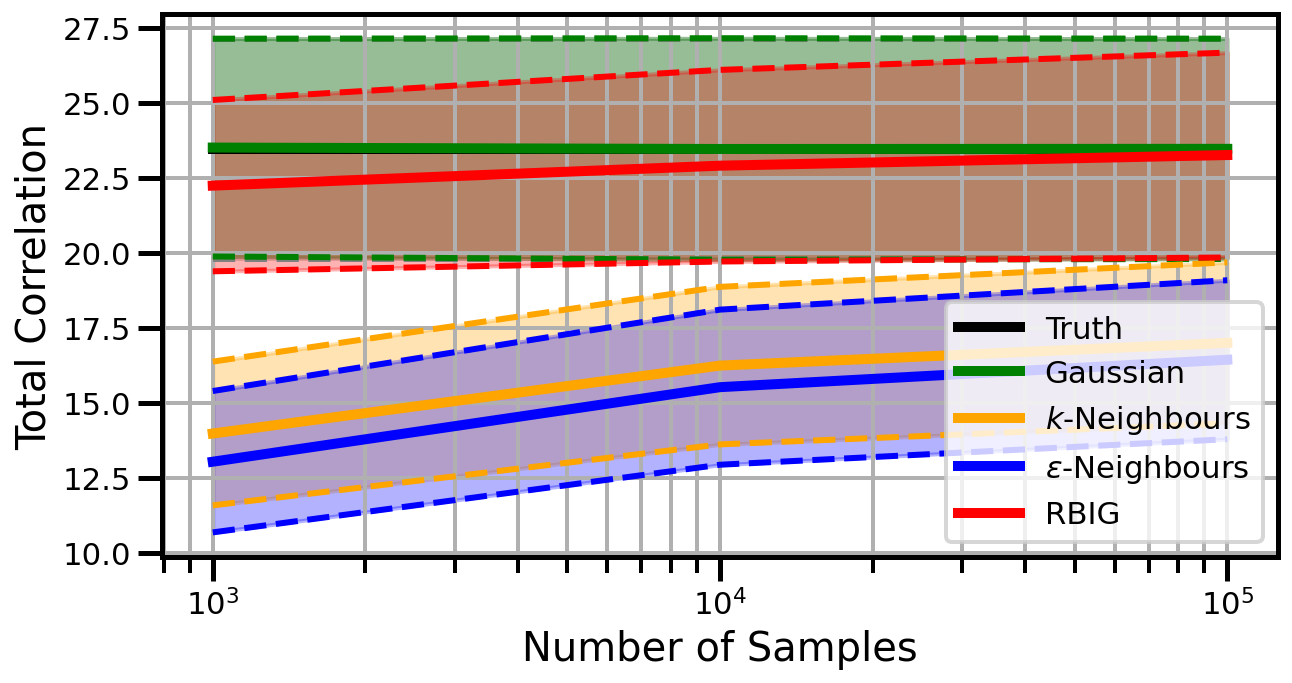

linear_rotation
Dimensions: 2


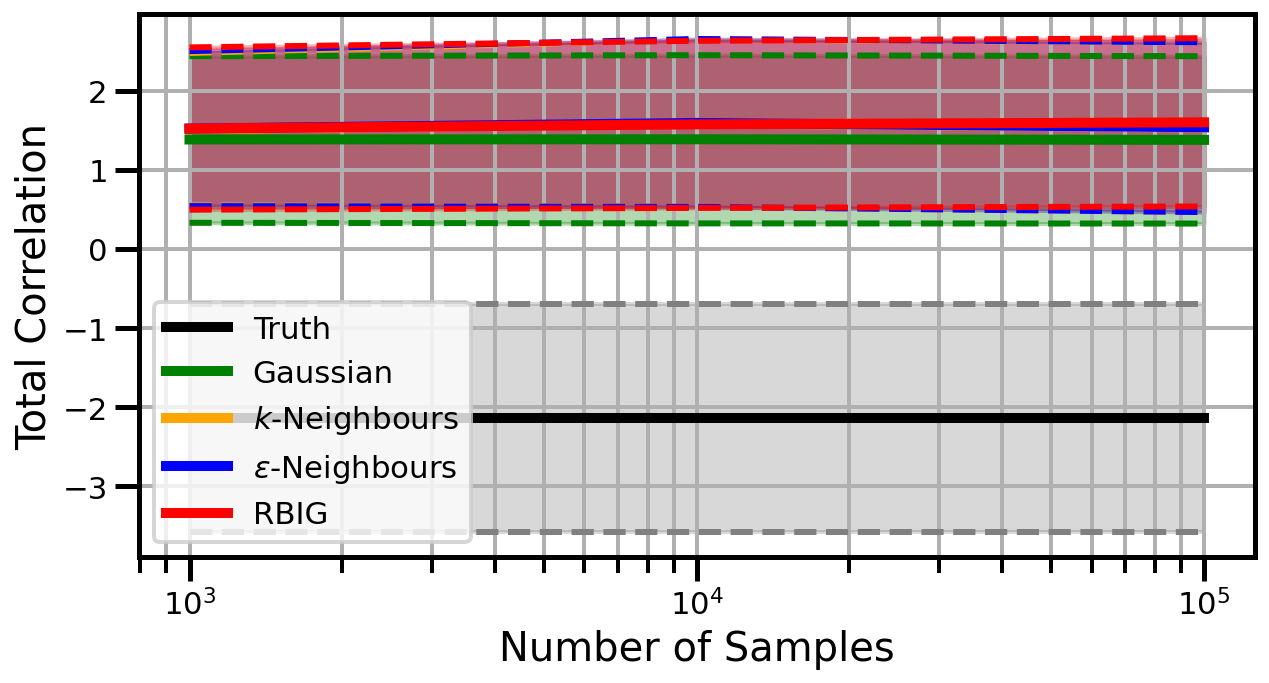

Dimensions: 3


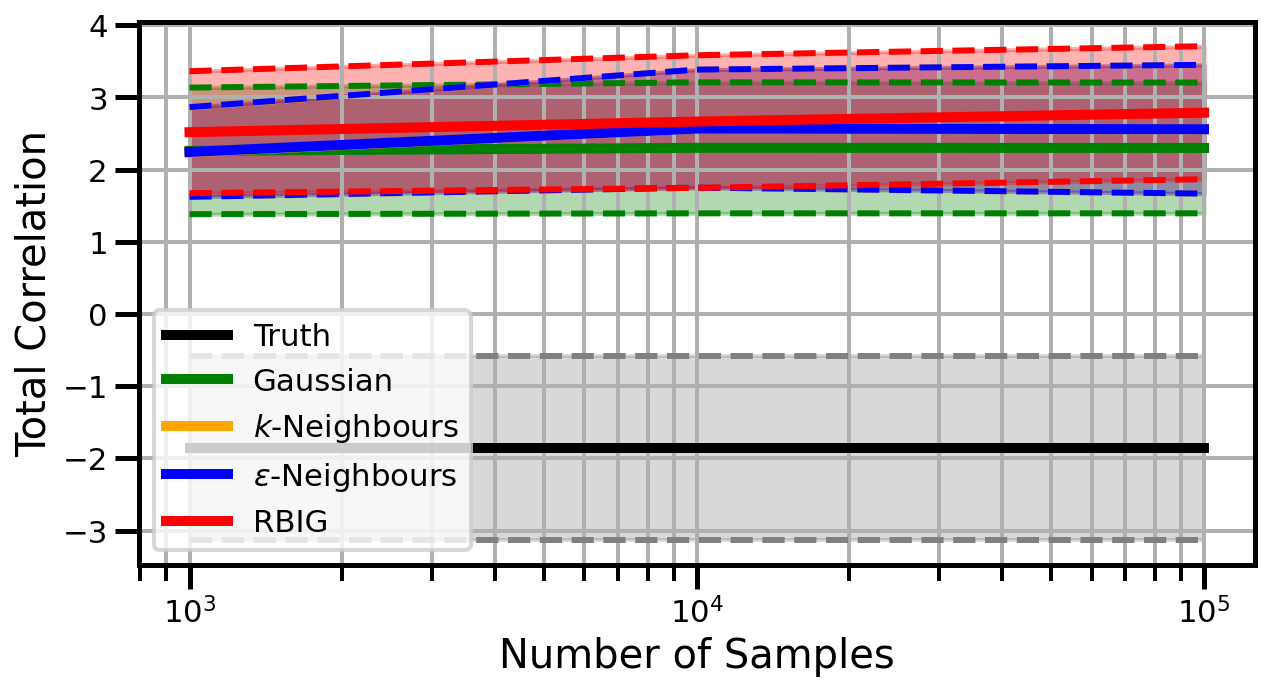

Dimensions: 5


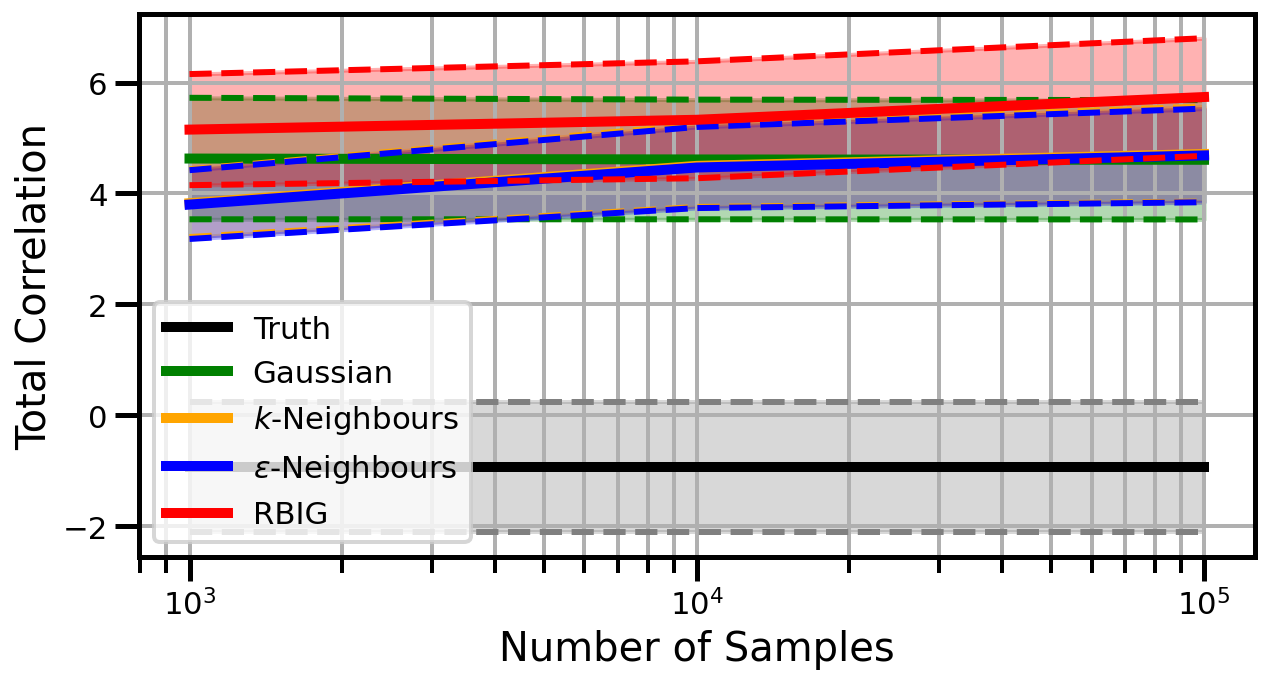

Dimensions: 10


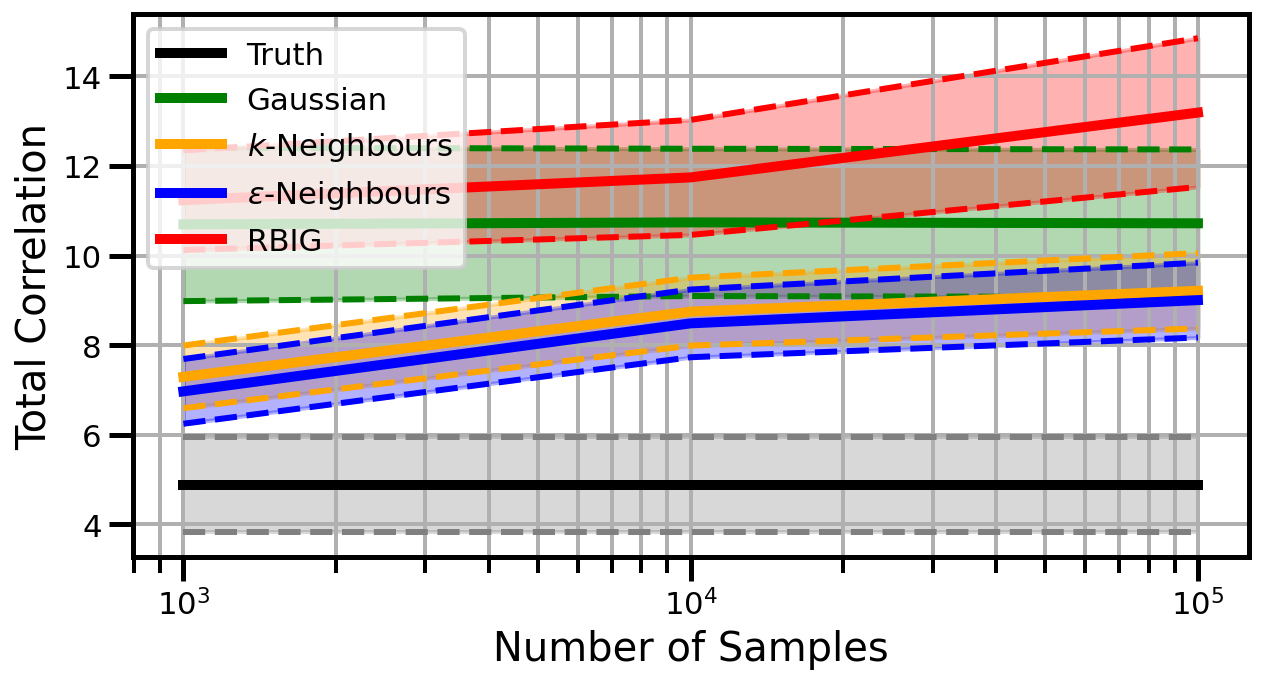

Dimensions: 15


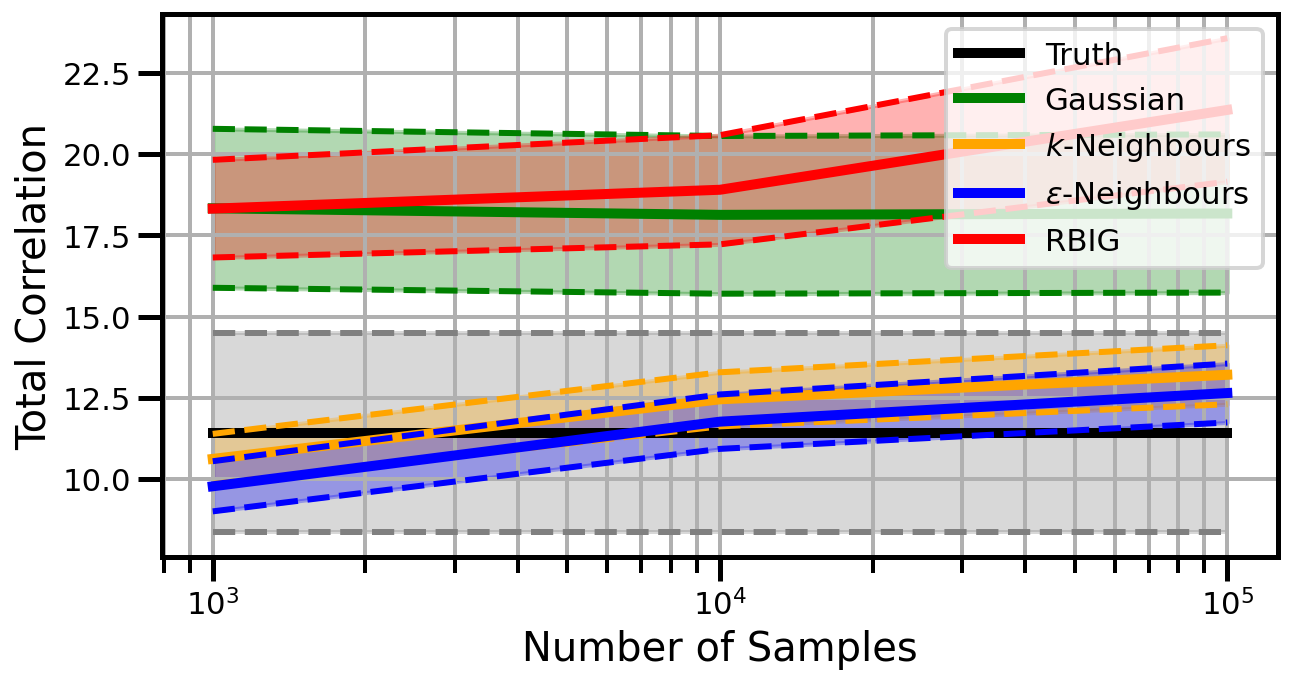

studentt
Dimensions: 2


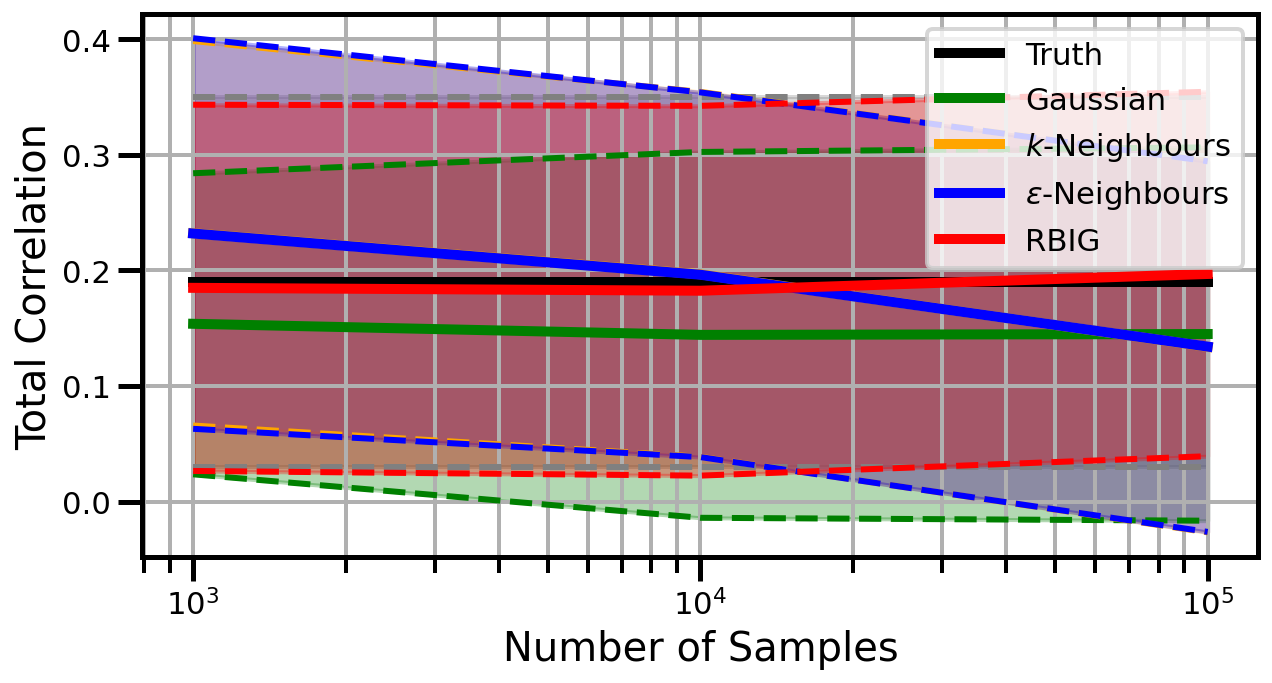

Dimensions: 3


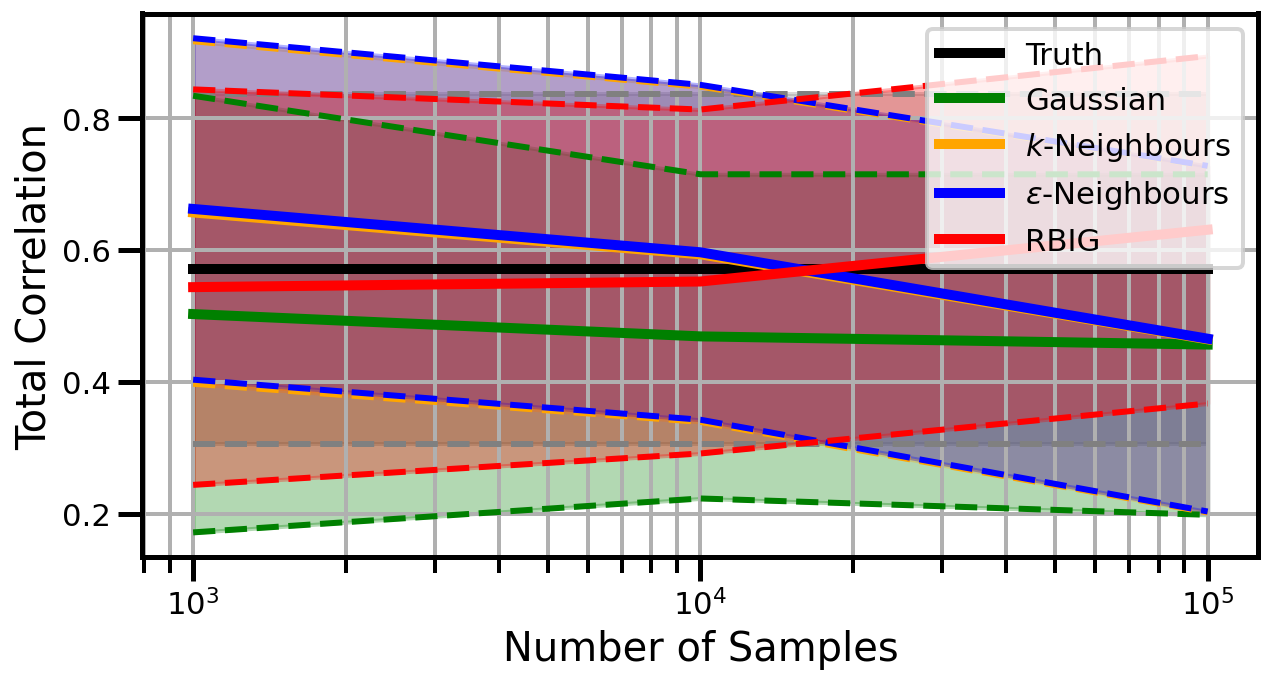

Dimensions: 5


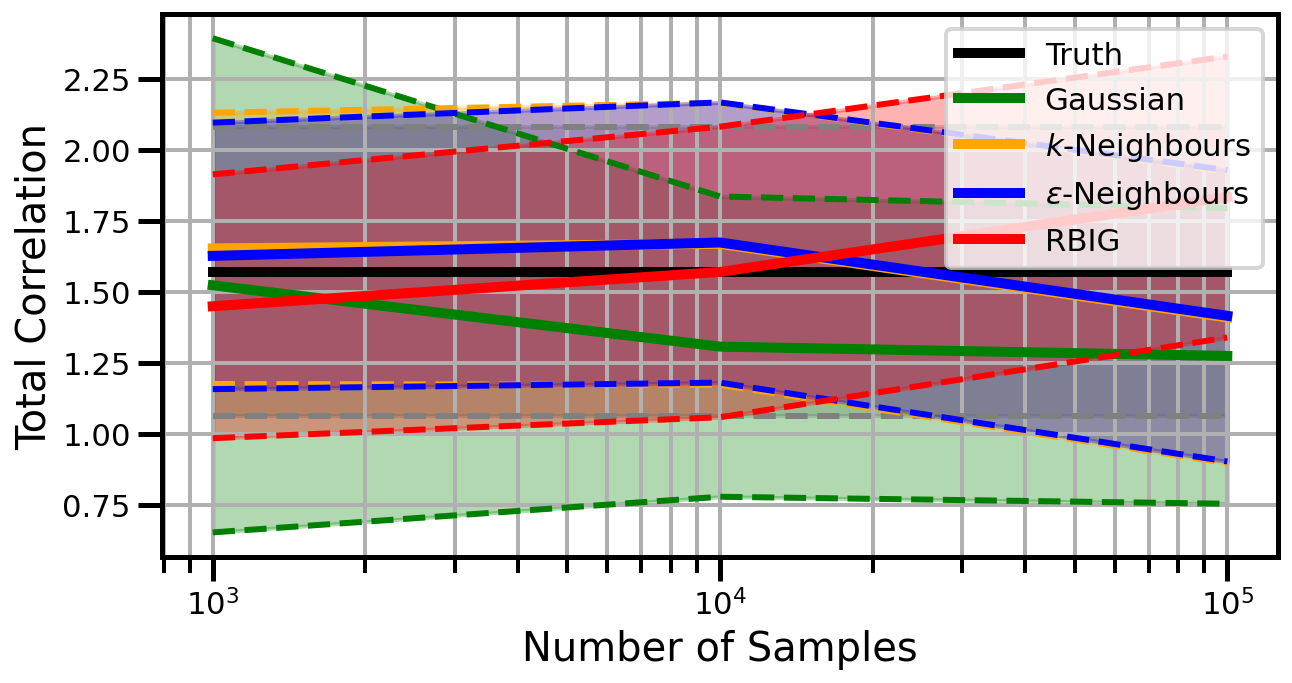

Dimensions: 10


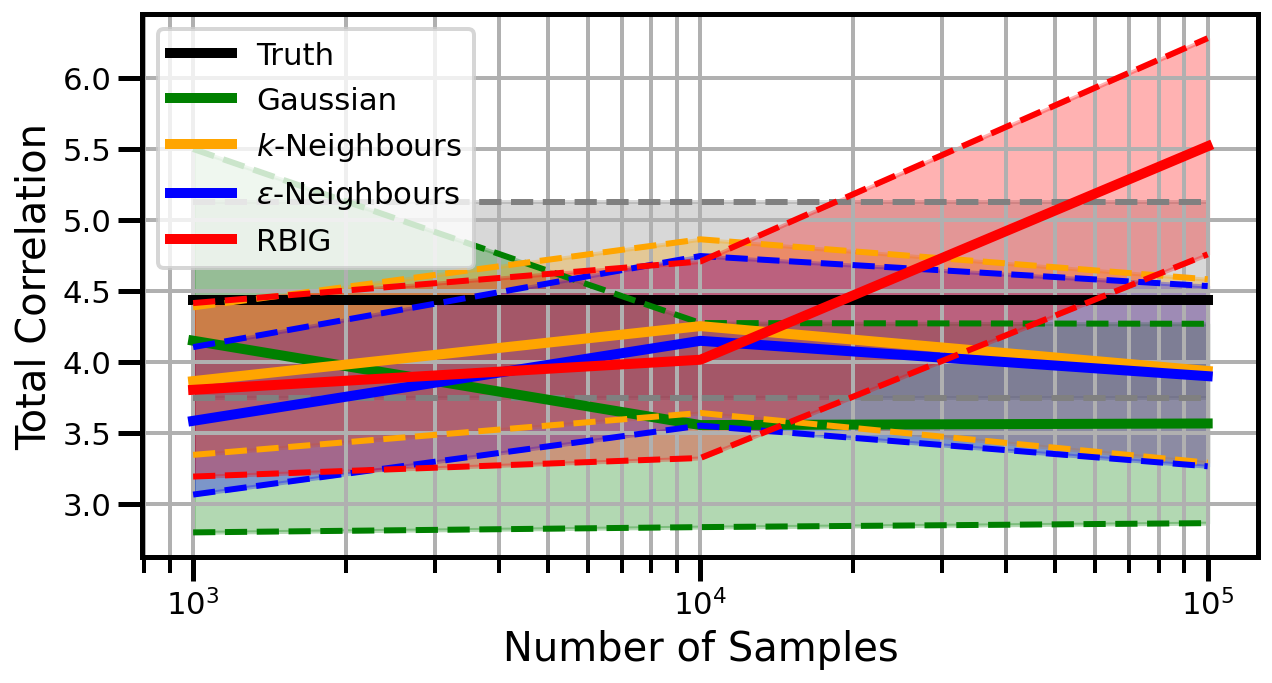

Dimensions: 15


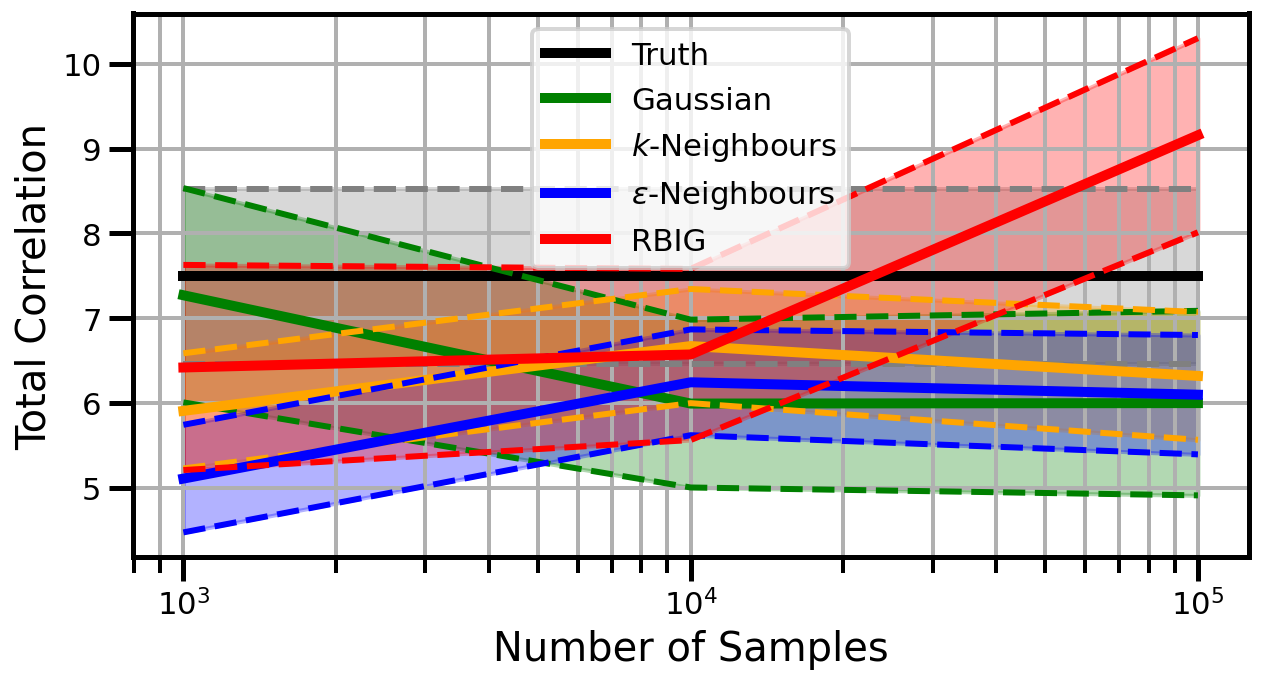

cauchy
Dimensions: 2


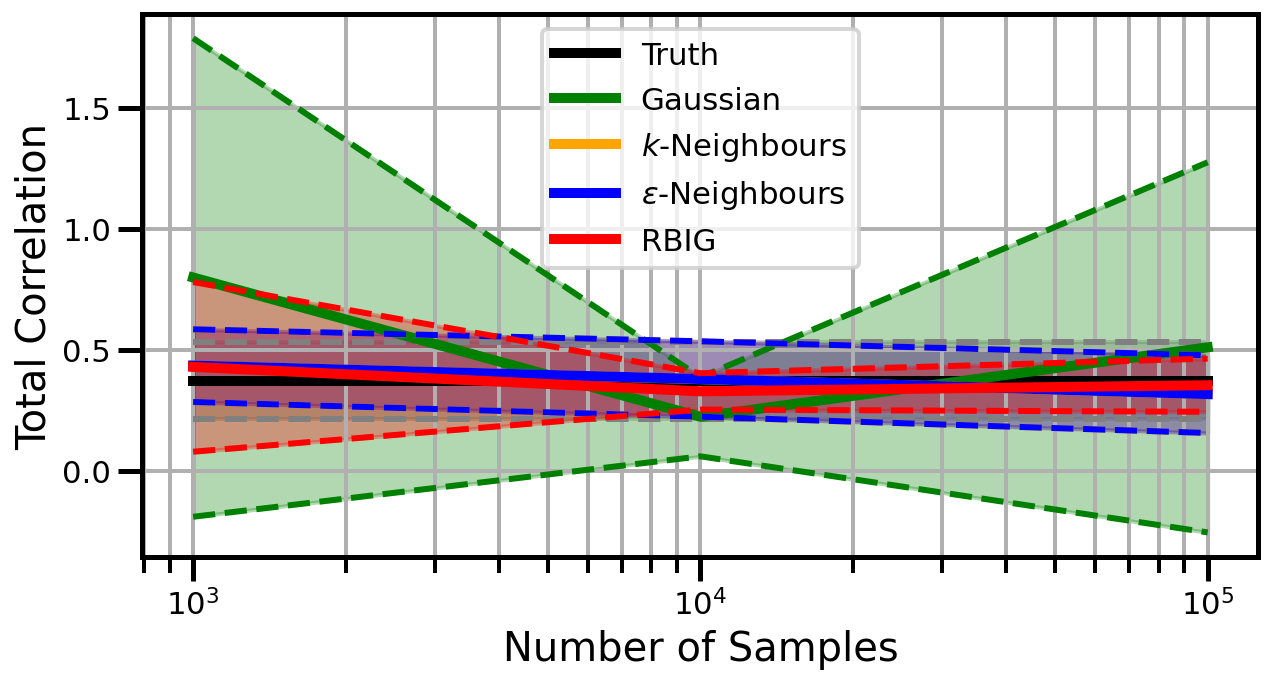

Dimensions: 3


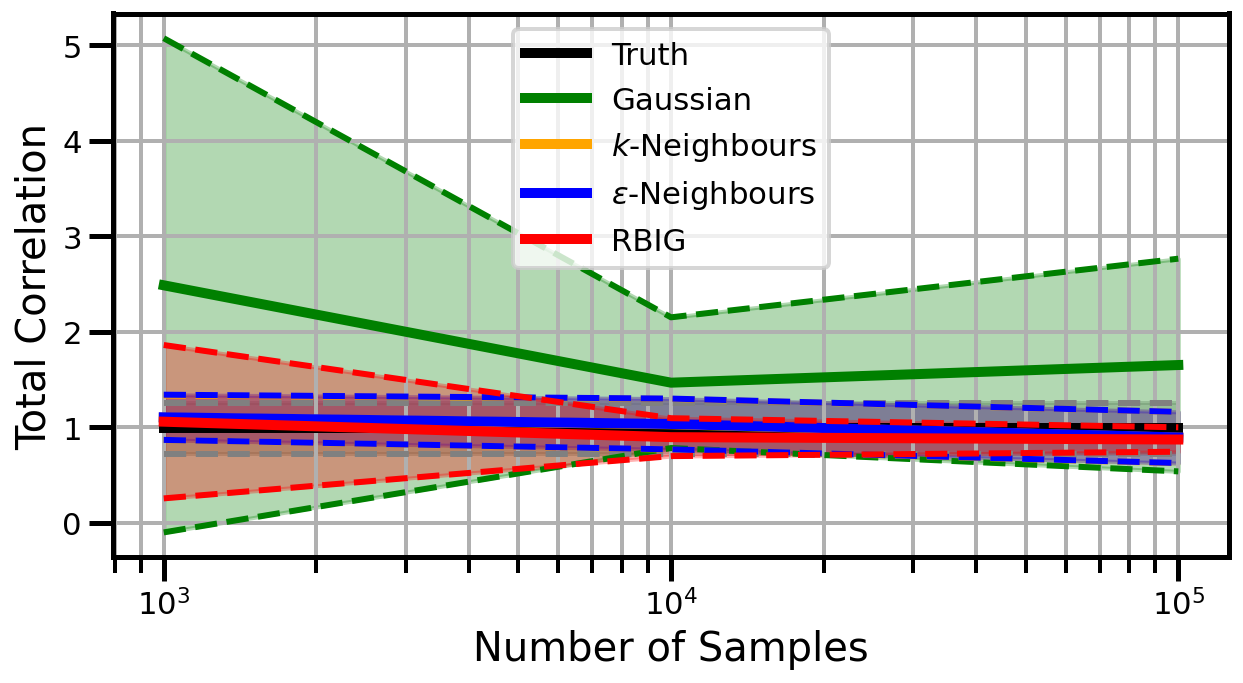

Dimensions: 5


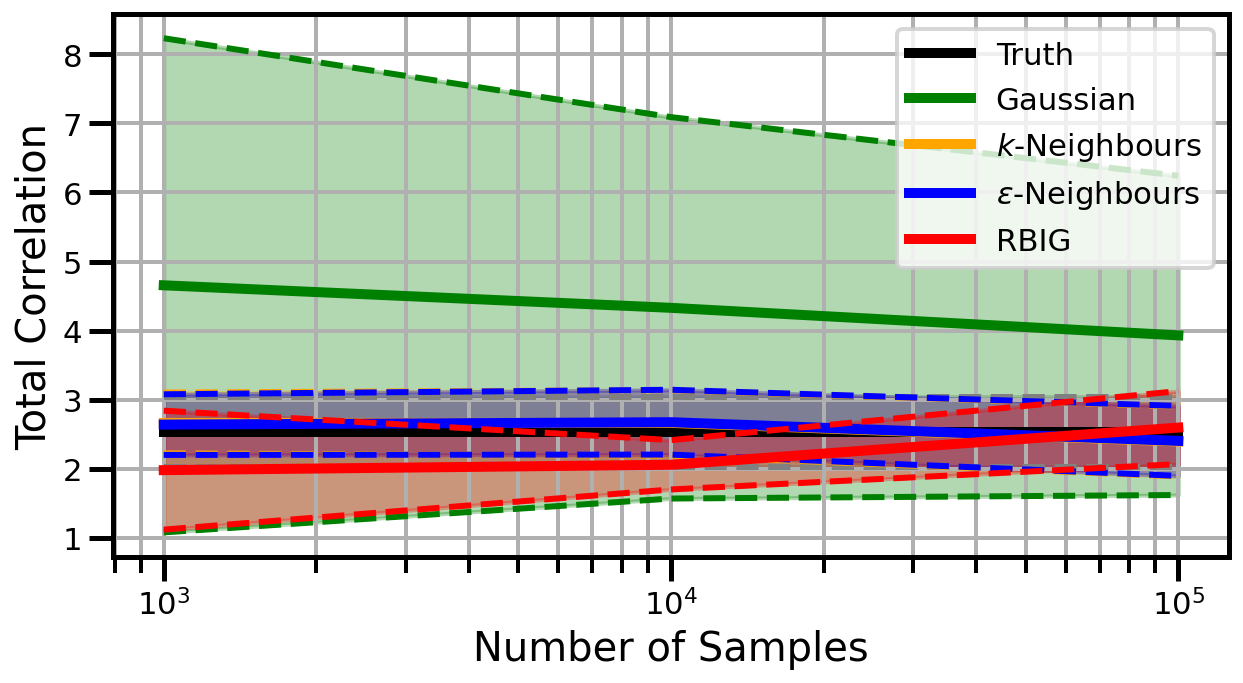

Dimensions: 10


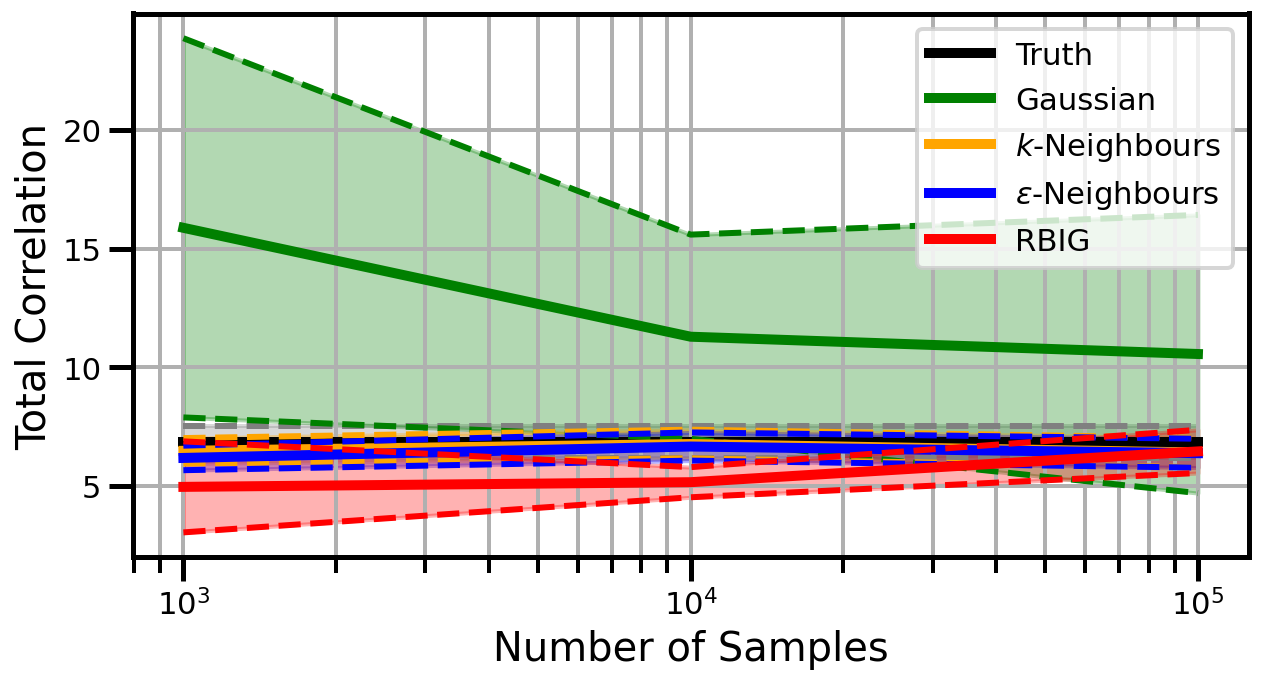

Dimensions: 15


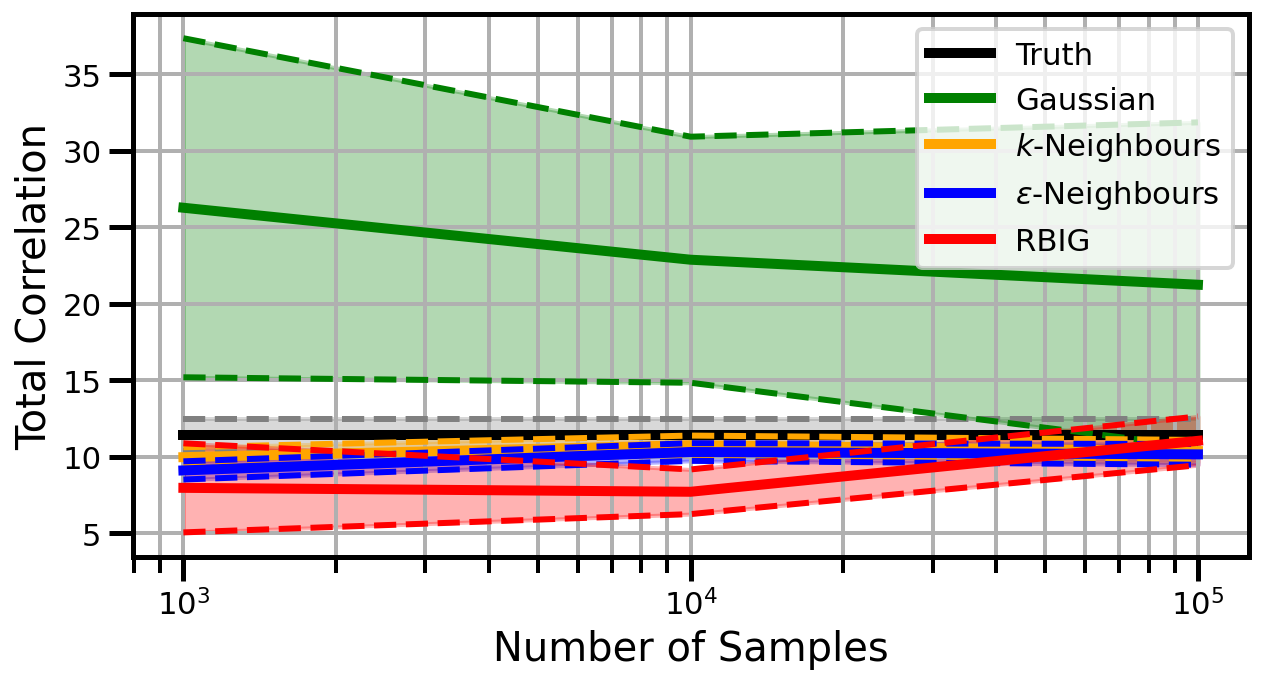

In [77]:
for idataset in datasets:

    print(idataset)
    for idims in [2, 3, 5, 10, 15]:
        print(f"Dimensions: {idims}")
        plot_results(results_xr, idataset, idims)

## Results

### Plot II - Sample Consistency

In [78]:
def get_sample_tc(df, model, dataset="gaussian"):

    df = df[df["model"] == model]
    df = df[df["dataset"] == dataset]

    # get true values
    df_true = df["samples"]
    df_approx = df["approx"]

    return df_approx, df_true

### Plot I - Indiscriminate

In [79]:
def get_mu_std(df, model, dataset="gaussian"):

    df = df[df["model"] == model]
    df = df[df["dataset"] == dataset]

    # get true values
    df_true = df["true"]
    df_approx = df["approx"]

    return df_approx, df_true

In [80]:
df_knn, df_true = get_mu_std(results_df, "gaussian")

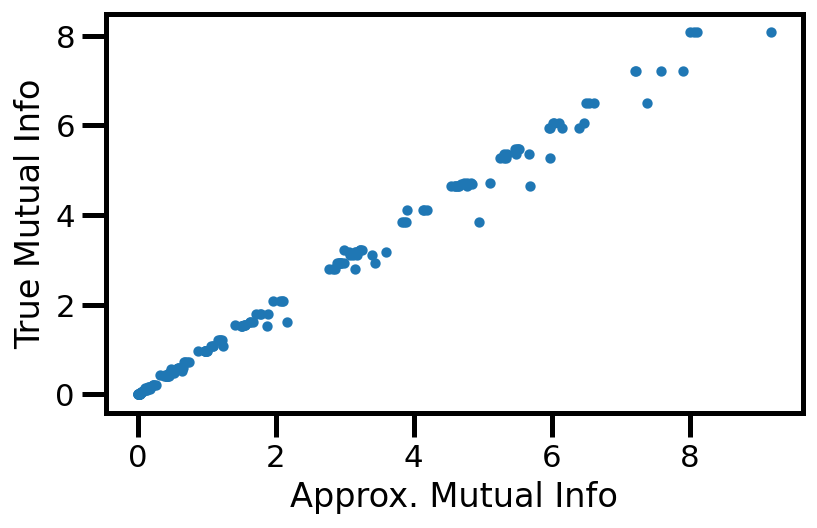

In [81]:
fig, ax = plt.subplots()

ax.scatter(df_knn.values, df_true.values, s=10)
ax.set(xlabel="Approx. Mutual Info", ylabel="True Mutual Info")
plt.tight_layout()
plt.show()
# wandb.log({f"scatter_gaussian_pearson_dim": wandb.Image(fig)})

## Results

In [84]:
def plot_results(results_df, model="gaussian", dataset="gaussian"):

    results_df = results_df[results_df["n_samples"] != 100]

    df_approx, df_true = get_mu_std(results_df, model, dataset)

    min_val, max_val = df_true.min(), df_true.max()
    fig, ax = plt.subplots()

    ax.scatter(df_approx.values, df_true.values, s=10, zorder=3)
    ax.plot(
        [min_val, max_val],
        [min_val, max_val],
        color="black",
        linestyle="-",
        linewidth=2,
    )
    ax.set(xlabel="Est. Mutual Info", ylabel="True Mutual Info")
    ax.set_title(f"Data: {dataset} | Model: {model}")
    ax.grid()
    plt.tight_layout()
    plt.gcf()
    wandb.log({f"accuracy_{dataset}_{model}": wandb.Image(fig)})
    plt.show()
    plt.close(fig)

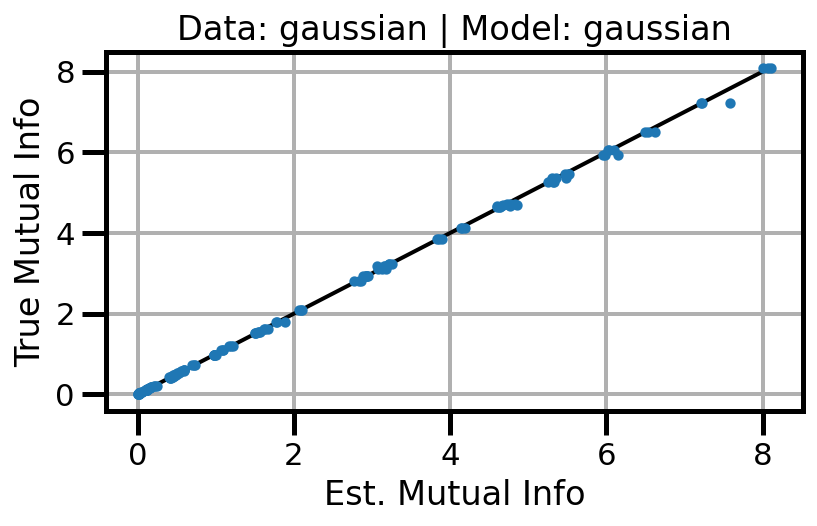

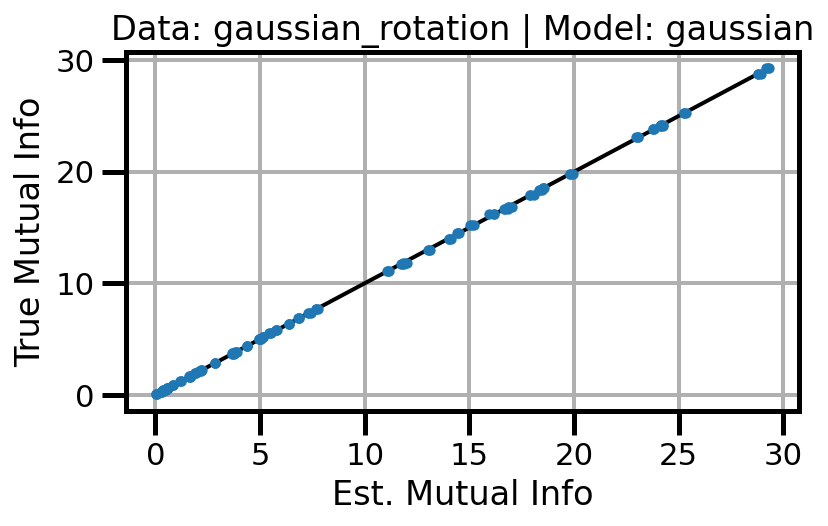

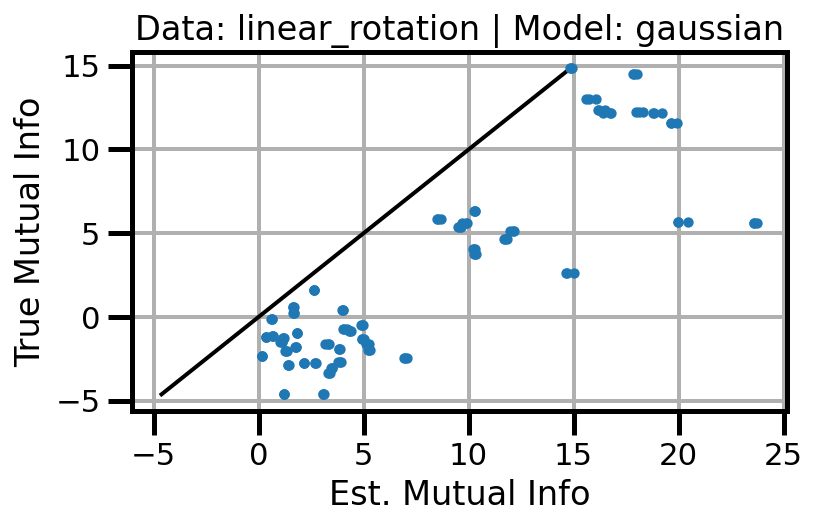

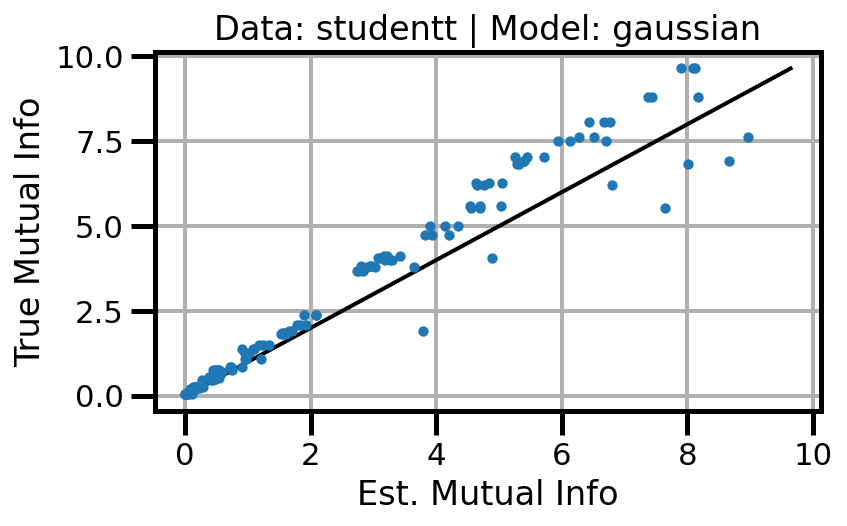

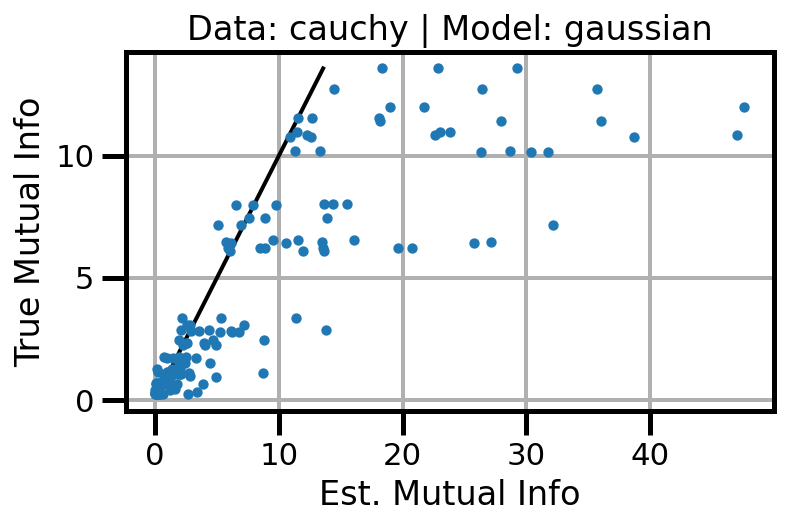

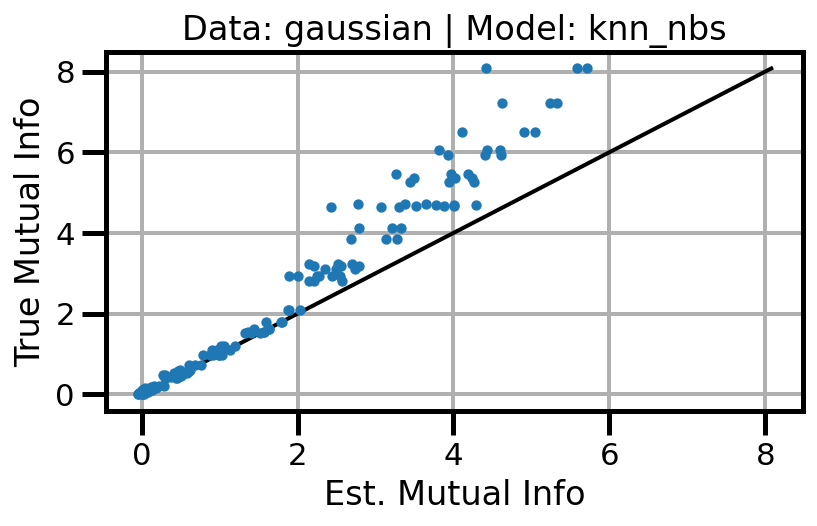

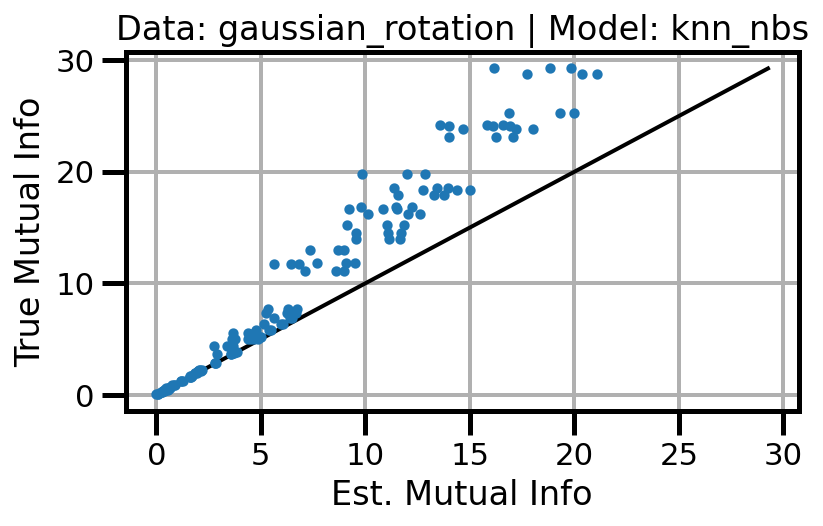

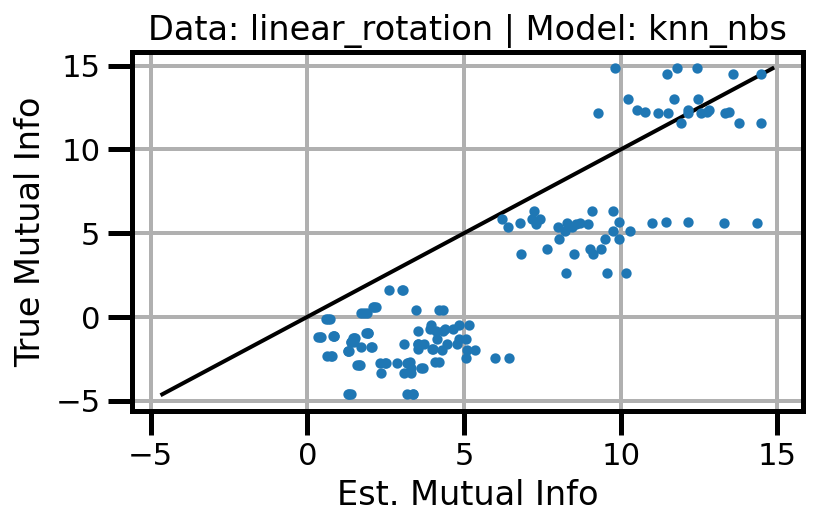

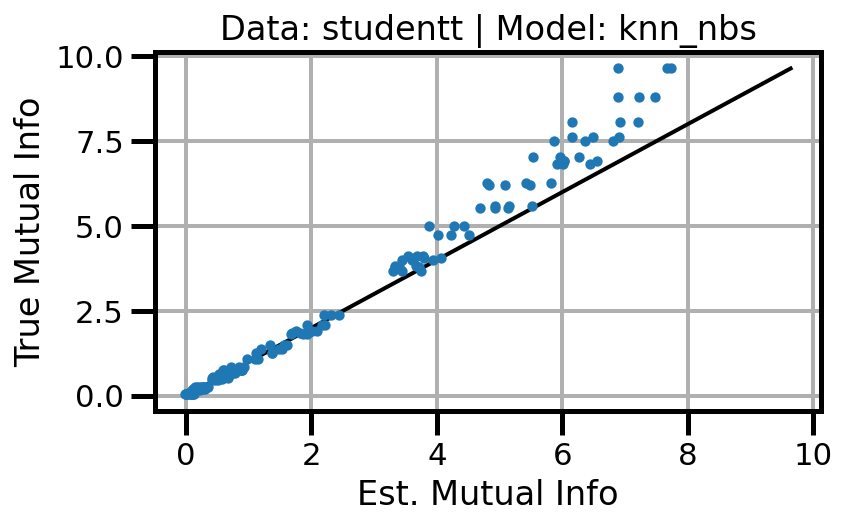

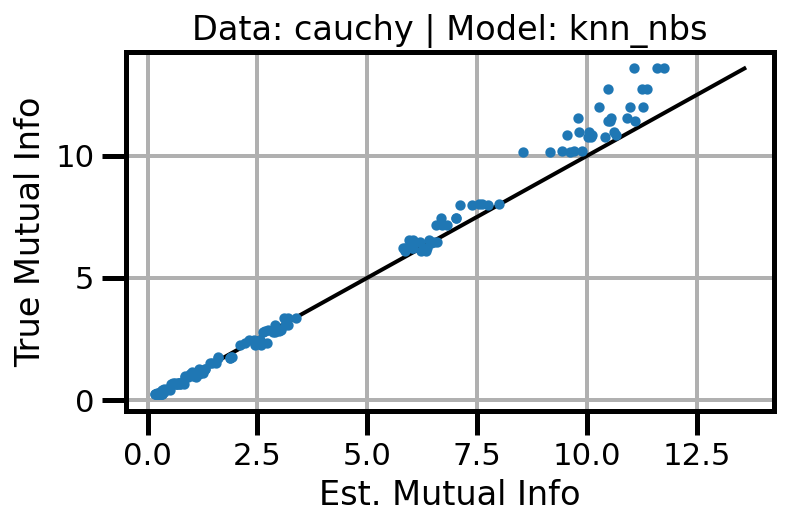

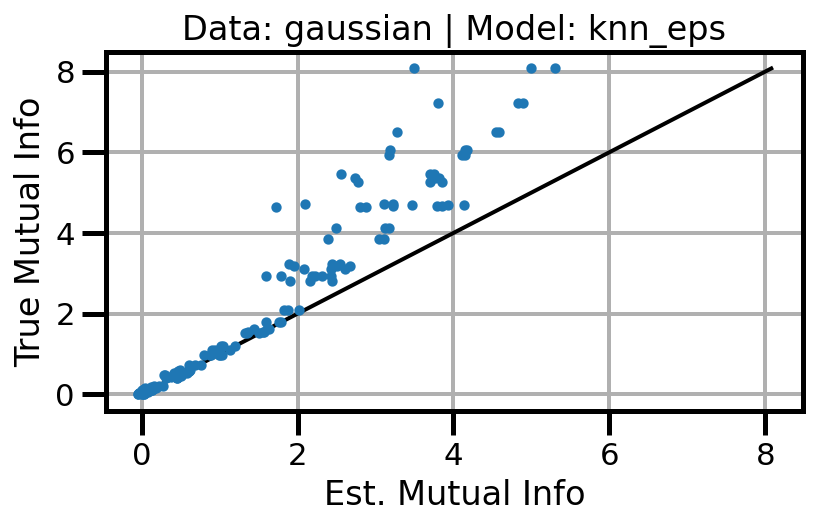

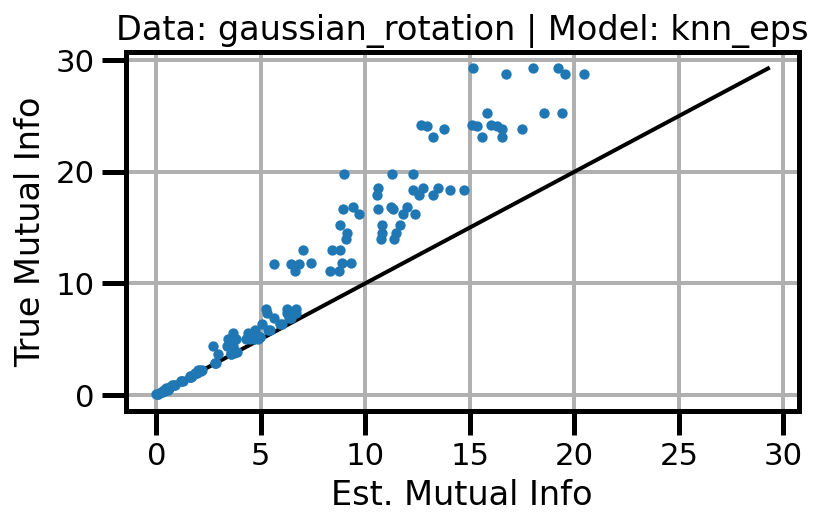

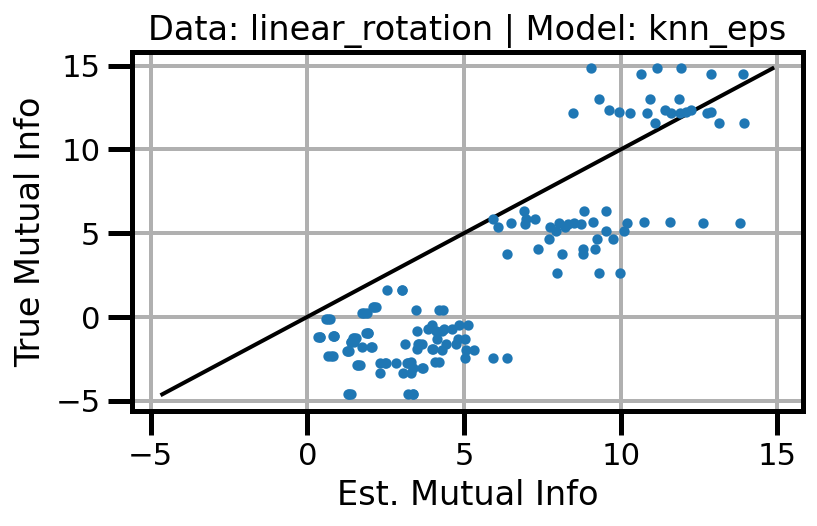

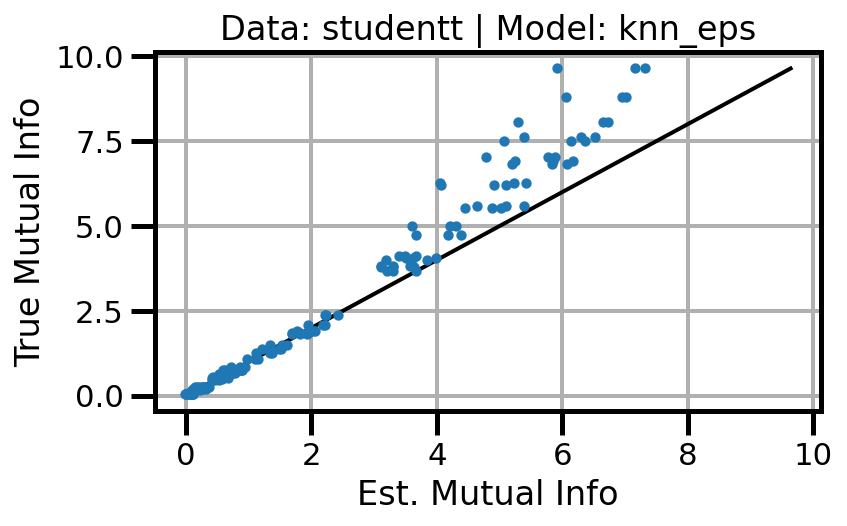

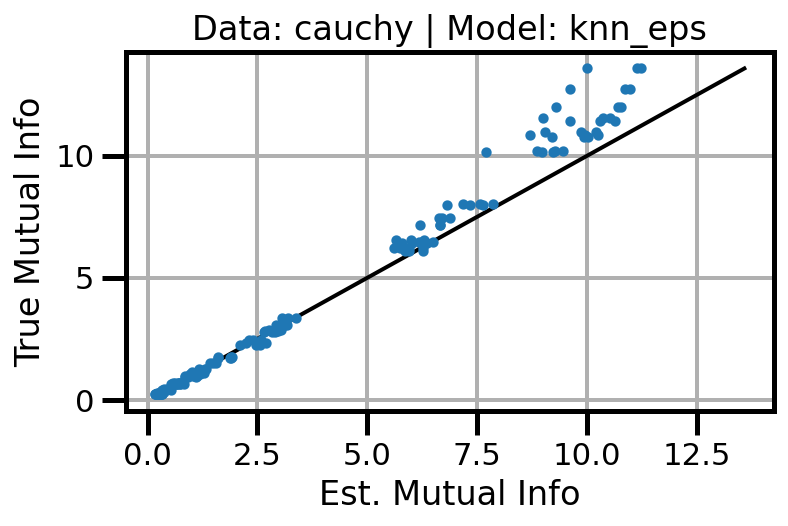

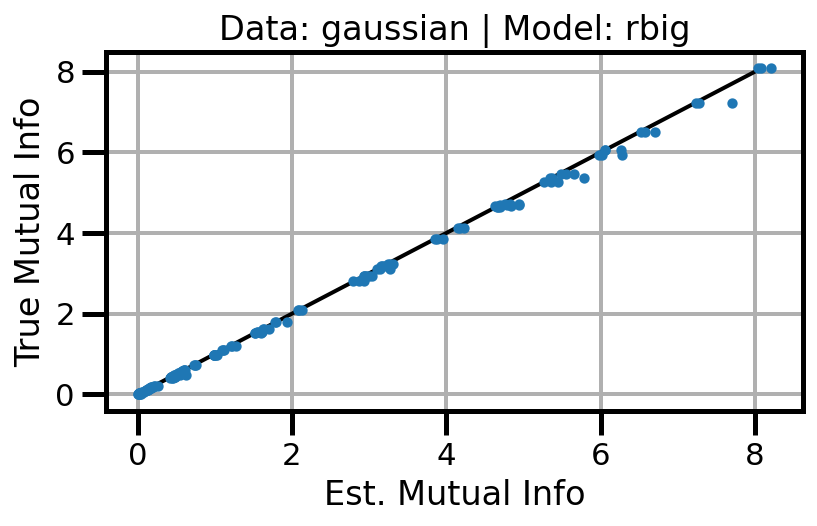

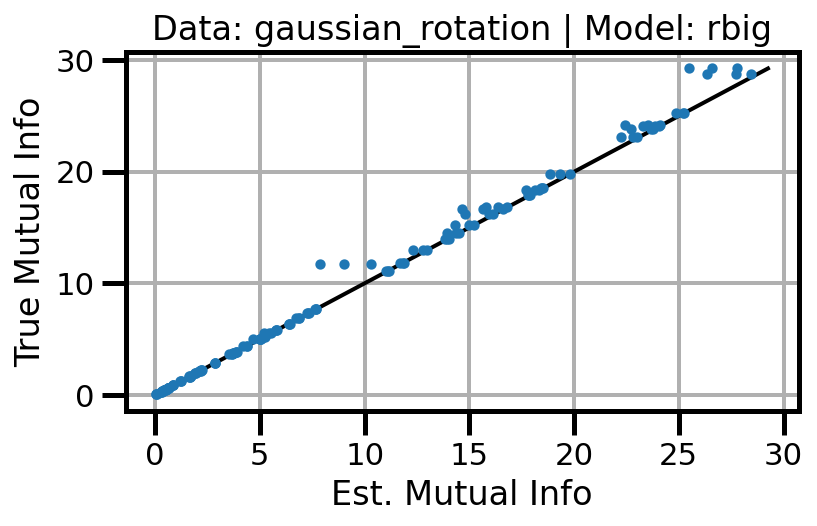

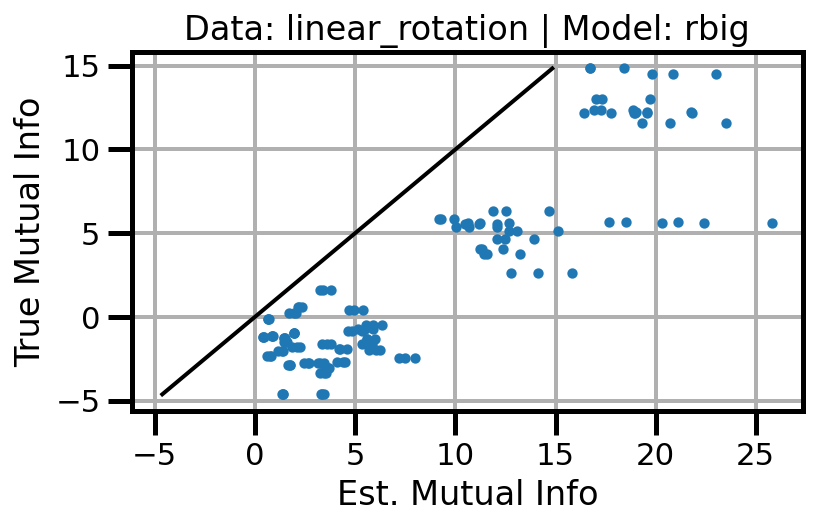

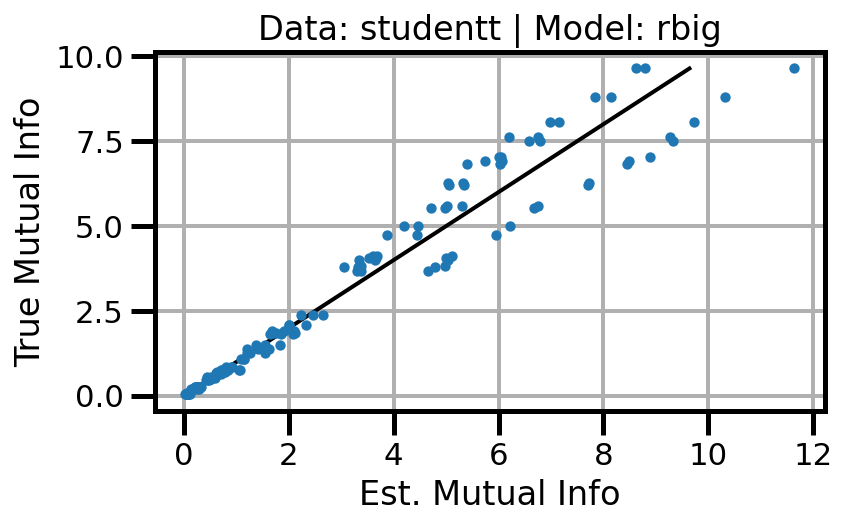

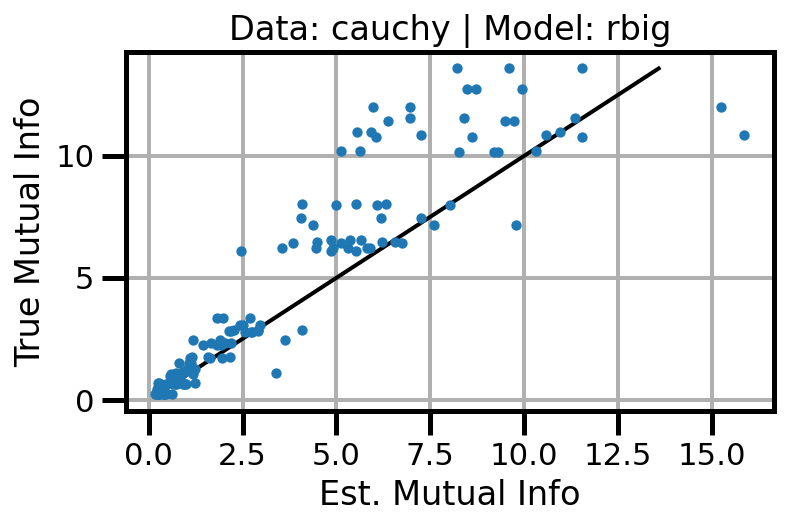

In [85]:
models = [
    "gaussian",
    "knn_nbs",
    "knn_eps",
    "rbig",
]

for imodel in models:
    for idataset in datasets:

        plot_results(results_df, model=imodel, dataset=idataset)